 <font size="6">Нейронные сети</font>

#  Ограничения Линейного классификатора

Вспомним материал лекции №2:

Мы обучали линейный классификатор на датасете CIFAR-10

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/input_img_scalar_product_add_bias_get_scores.jpg" width="600">

- Основная операция линейного классификатора: скалярное произведение
- Функции потерь: SVM Loss, Cross-Entropy Loss
- Метод обучения: градиентный спуск
- Оценка точности линейного классификатора на CIFAR-10: ~0.38

Попробуем визуализировать шаблоны (матрицы весовых коэффициентов), получающиеся в результате обучения линейного классификатора.

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/L05/lc_mnist_weights.txt
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/L05/lc_cifar10_weights.txt

Сначала посмотрим на веса, которые выучивает линейный классификатор для датасета MNIST:

Shape with bias: torch.Size([785, 10])
Shape without bias: torch.Size([784, 10])


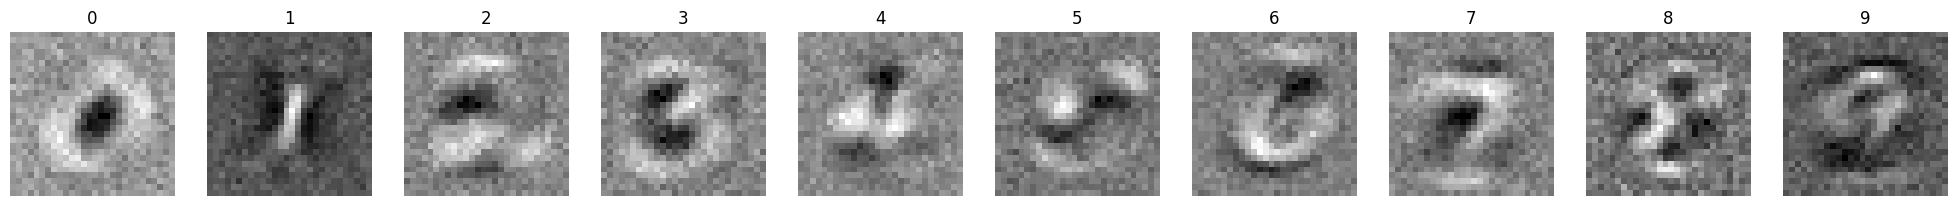

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Display templates
plt.rcParams["figure.figsize"] = (25, 10)

W = torch.from_numpy(np.loadtxt("lc_mnist_weights.txt"))  # load weigths, shape 3073x10
print(f"Shape with bias: {W.shape}")

# Remove bias
W = W[:-1, :]
print(f"Shape without bias: {W.shape}")

# Denormalize
w_min = torch.min(W)
w_max = torch.max(W)
templates = 255 * (W - w_min) / (w_max - w_min)

# Display templates
labels_names = [str(i) for i in range(10)]
for i in range(10):
    plt.subplot(1, 10, i + 1)
    img = templates[:, i].view(1, 28, 28).permute(1, 2, 0).type(torch.uint8)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(labels_names[i])

А теперь взглянем на шаблоны линейного классификатора для датасета CIFAR-10:

Shape with bias: torch.Size([3073, 10])
Shape without bias: torch.Size([3072, 10])


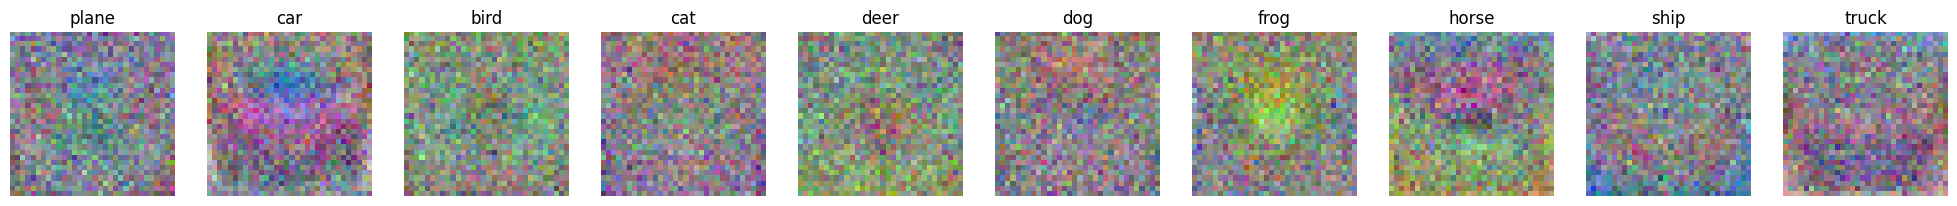

In [ ]:
# Display templates
plt.rcParams["figure.figsize"] = (25, 10)

W = torch.from_numpy(
    np.loadtxt("lc_cifar10_weights.txt")
)  # load weigths, shape 3073x10
print(f"Shape with bias: {W.shape}")

# Remove bias
W = W[:-1, :]
print(f"Shape without bias: {W.shape}")

# Denormalize
w_min = torch.min(W)
w_max = torch.max(W)
templates = 255 * (W - w_min) / (w_max - w_min)

# Display templates
labels_names = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
for i in range(10):
    plt.subplot(1, 10, i + 1)
    img = templates[:, i].view(3, 32, 32).permute(1, 2, 0).type(torch.uint8)
    plt.imshow(img)
    plt.axis("off")
    plt.title(labels_names[i])

Качественное отличие датасетов MNIST и CIFAR-10 заключается в том, что в CIFAR-10 выше **внутриклассовая вариативность**. Это значит, что изображения внутри каждого класса могут достаточно сильно различаться. Лошадь может стоять головой направо или налево, на фоне леса или на фоне поля, и т. д. В датасете MNIST внутриклассовая вариативность гораздо ниже: все цифры отцентрированы, и изображения одной и той же цифры в среднем гораздо больше похожи друг на друга.

Ограничение линейного классификатора состоит в том, что для каждого класса существует только один шаблон. Шаблон каждого класса будет пытаться вобрать в себя информацию обо всех объектах класса сразу (например, на получившихся шаблонах для CIFAR-10 у лошади две головы, машина красная и т. д.). Сильная внутриклассовая вариативность будет мешать линейному классификатору запоминать разные варианты объектов одного класса, и это ограничивает точность модели.

##  ХОR — проблема

У линейного классификатора есть существенные ограничения применения. Рассмотрим такую задачу: на вход модели подаётся упорядоченный набор из двух чисел согласно таблице истинности некоторой логической функции. Задача линейного классификатора — сопоставить этим числам их класс согласно таблице. Графически два входных числа можно изобразить как координаты точек на плоскости, а знаком $+/-$ обозначить их истинный класс. Тогда задача классификатора — построить линию, отделяющую "плюсы" (класс 1) от "минусов" (класс 0).

В случае моделирования логических функций "И" и "ИЛИ" сложностей не возникает: в пространстве признаков без труда можно провести прямую линию, разделяющую точки разных классов. В случае моделирования логической функции "исключающее ИЛИ" (XOR) видно, что одной линией разделить точки разных классов геометрически невозможно — точки, размеченные по таблице истинности XOR, являются **линейно неразделимыми**.

То есть, линейный классификатор уже не может справиться с этой, казалось бы, простой задачей.

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/xor_problem.png"  width="900">

## Проблемы классификации более сложных объектов

Человек узнает на изображении кошку или любой другой объект, руководствуясь целостным представлением о данном объекте на изображении. Такое целостное интуитивное представление об объектах для компьютера напрямую недоступно. С точки зрения компьютера, изображение представляет собой не более чем таблицу из чисел, кодирующих цвета всех его пикселей. Небольшое цветное изображение (с тремя  цветовыми каналами: красным, зеленым и синим) в разрешении $32 \times 32$ для компьютера представлено просто упорядоченным набором из $32 \times 32 \times 3 = 3072 $ целых чисел.

Легко себе представить ситуацию, в которой изображения одного и того же объекта будут значительно отличаться на масштабе отдельных пикселей. Так, например, один и тот же кот может быть представлен на фотографии в различных позах, фотографии могут отличаться условиями освещения, яркостью или контрастностью. Кроме того, на одной из фотографий может быть изображен только фрагмент объекта (например, только хвост). Все эти факторы не являются преградой для распознавания человеком, и мы хотим потребовать того же и для реализованных на компьютере алгоритмов классификации.


Вот лишь малая часть параметров, которые будут влиять на точность распознавания классификатора:


<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/problem_classification_difficult_object.png" width="700">

Все описанные выше сложности обобщенно можно назвать **внутриклассовой вариативностью**: мы можем приписывать к одному классу объекты, которые допускают широкий спектр определения. Так, например, мы обобщаем классом "кошка" кошек различных пород, размеров и возрастов. "Хороший" алгоритм классификации должен быть устойчив к внутриклассовой вариативности и верно распознавать все возможные варианты объектов.

Один из подходов к решению этой проблемы — модифицировать модель таким образом, чтобы у нее внутри было не по одному шаблону на каждый класс, а по несколько (скажем, 100 шаблонов вместо 10 при десяти классах). Тогда бы модель имела возможность запоминать разные объекты одного класса и далее использовать эти промежуточные шаблоны для разбиения объектов на классы.

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/modified_model.png"  width="600">

$ \large h=W_1 \times x$

$ \large S=W_2 \times f(h)=W_2 \times f(W_1 \times x)$

Реализуем эту модель на основе линейного классификатора из лекции №2:

Применим к выходам классификатора еще один классификатор. Будет ли работать данная модель?

In [ ]:
import random


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

In [ ]:
x = torch.rand(3072)  # random image
W1 = torch.randn(3072, 100) * 0.0001  # without bias
W2 = torch.randn(100, 10) * 0.0001  # without bias
scores1 = x.matmul(W1)  # matrix multiplication, equivalent x@W1
scores2 = scores1.matmul(W2)  # matrix multiplication, of the next classifier

print(f"First classifier shape: {scores1.shape}")
print(f"Second classifier shape: {scores2.shape}")

First classifier shape: torch.Size([100])
Second classifier shape: torch.Size([10])


Нетрудно заметить, что последовательное применение двух классификаторов к входным данным эквивалентно применению одного классификатора с матрицей весов, равной произведению двух матриц весов классификаторов, примененных последовательно.

$$ scores_1 = W_1 \cdot x $$

$$ scores_2 = W_2 \cdot scores_1 = W_2 \cdot W_1 \cdot x $$

$$ W = W_2 \cdot W_1 $$

$$ scores_2 = W \cdot x $$

Для того, чтобы последовательно примененные классификаторы не вырождались в один, необходимо применить нелинейность к их выходам. Например, пропустим результат применения первой матрицы весов через сигмоиду:

$$\sigma(s)=\frac{1}{1+e^{-s}}$$

In [ ]:
scores1 = x.matmul(W1)
print(
    f"\nFirst 8 elements of Scores1: {scores1[:8]}"
)  # take the first 8 values for visualization
activations = torch.sigmoid(scores1)  # only values greater than zero
print(f"\nActivations {activations[:8]}")  # take the first 8 values for visualization
scores2 = activations.matmul(W2)
print(f"\nScores2 {scores2}")


First 8 elements of Scores1: tensor([-0.0037,  0.0029,  0.0009,  0.0038,  0.0030,  0.0022,  0.0028,  0.0020])

Activations tensor([0.4991, 0.5007, 0.5002, 0.5009, 0.5007, 0.5005, 0.5007, 0.5005])

Scores2 tensor([-6.6097e-04, -4.0941e-04, -2.0049e-04, -1.1673e-04,  9.7170e-04,
        -3.0337e-04, -5.1134e-05,  7.1515e-04,  1.7552e-03,  8.0079e-05])


Теперь вычисления выглядят так:

$$ scores_1 = W_1 \cdot x $$

$$ activations = σ(scores_1) $$

$$ scores_2 = W_2 \cdot activations = W_2 \cdot σ(scores_1)$$

Такая конструкция называется **функцией активации**. И мы уже пользовались подобной, когда разбирали Cross-Entropy Loss (Softmax).

Приведем код в порядок:

In [ ]:
class NeuralNet:
    def __init__(self):
        self.W1 = torch.randn(3072, 100) * 0.0001
        self.W2 = torch.randn(100, 10) * 0.0001

    def predict(self, x):
        scores1 = x.matmul(self.W1)  # Linear
        activations1 = torch.sigmoid(scores1)  # activation ReLU
        scores2 = activations1.matmul(self.W2)  # Linear
        return scores2


x = torch.rand(3072)  # image
model = NeuralNet()
scores = model.predict(x)
print(f"scores: \n {scores}")

scores: 
 tensor([-3.0459e-04, -4.3039e-04,  2.9862e-04, -1.0788e-03, -5.7298e-05,
         9.4889e-04,  8.5047e-06, -8.5582e-05, -2.2691e-04,  2.5647e-04])


Ядром вычислений по-прежнему является скалярное произведение входов с весовыми коэффициентами.


Формула скалярного произведения:

$$\large \boldsymbol{w} \cdot \boldsymbol{x} = w_0 \cdot x_0 + w_1 \cdot x_1 + \cdots + w_{n-1} \cdot x_{n-1},$$

где $n$ — длина векторов.

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/dot_product.png" width="400">

Для изображения выше:

$\boldsymbol{w} \cdot \boldsymbol{x} = 1 \cdot 1 + 2 \cdot 0 + (-1) \cdot 4 + 0 \cdot (-2) = -3$

В библиотеке NumPy скалярное произведение вычисляется с помощью операции [`np.dot(w, x)`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html).

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/input_weght_out.png"  width="700">


И оно соответствует одному слою искусственной нейронной сети (за исключением функции активации).

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/scalar_product_add_bias.png" width="800">

То, как добавление в модель скрытых слоев с нелинейностями позволяет решать линейно неразделимые задачи (вроде XOR или более сложные), можно пронаблюдать [в интерактивном тренажере от TensorFlow.](http://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=0&networkShape=&seed=0.62952&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

#  Многослойные сети

По мере развития мощности компьютеров, теоретической базы, появления больших датасетов и метода обратного распространения ошибки, появилась возможность строить более сложные сети — многослойные нейронные сети или же в современном понимании просто **нейронные сети**.

Пример **полносвязной (fully-connected network)** нейронной сети с двумя скрытыми слоями:

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/nn_fully_connected.png" width="400">

#  Обучение нейронной сети

Нейронная сеть в процессе **обучения** последовательно обрабатывает все объекты из обучающей выборки.
Предъявление нейронной сети всех объектов обучающей выборки по одному разу называется **эпохой обучения**.



Обучающую выборку разделяют на две части: непосредственно использующуюся для обучения (train data) и валидационную (validation data). На валидационных данных каждую эпоху происходит оценка качества обучения. Стратегия разделения на train и validation подвыборки может быть произвольной, но при разделении следует заботиться о том, чтобы эти подвыборки были "похожи".

В ходе обучения ошибка работы модели измеряется на обучающих и валидационных данных для контроля **переобучения** (overfitting). В случае возникновения переобучения нейронная сеть начинает терять обобщающую способность, что можно заметить по возникновению роста ошибки на валидационной подвыборке в ходе процесса обучения — в случае переобучения нейронная сеть просто "зазубривает" примеры из обучающей подвыборки, а не аппроксимирует искомую функциональную зависимость между признаками и целевой переменной.

##  Прямое и обратное распространение

Рассмотрим процесс **обучения с учителем** (supervised learning) нейронной сети с прямым распространением сигнала (feedforward neural network). В ходе такого процесса мы хотим аппроксимировать при помощи нейронной сети функциональную зависимость между некоторым набором входных сигналов (признаков) и соответствующим им набором выходных сигналов (целевой переменной), используя множество эталонных пар вход-выход.

На этапе **прямого распространения** (forward pass) нейронной сети на вход подаются объекты из тренировочной выборки, вычисляется выход сети, и при помощи **функции потерь** (loss function) производится количественное сравнение полученных на выходе нейронной сети сигналов с эталонными значениями выхода. Далее, на этапе **обратного распространения** (backward pass), значение функции потерь будет использовано для подстройки параметров сети.

Подстройка параметров нейронной сети может происходить после вычисления функции потерь на одном примере (online) или же после накопления информации об отклике сети на пакете из нескольких примеров из обучающей выборки (**mini-batch**).

После завершения эпохи обучения и подстройки параметров модели происходит вычисление функции потерь на валидационных данных. Для валидационных данных производится только прямое распространение и вычисление функции потерь. **Подстройка параметров на валидационных данных не происходит.**

##  Веса сети

**Нейрон** является базовым элементом строения нейронной сети. У нейрона есть определенное количество "входов", которыми он "подключён" к выходным значениям других нейронов. Нейрон осуществляет суммирование приходящих в него входных значений, причём учитывает значения входов с определенными весовыми коэффициентами (или просто **весами**), которые в определенном смысле характеризуют их значимость. Веса сети являются вещественными числами и могут быть как положительными, так и отрицательными. Именно веса нейрона являются изменяемыми параметрами и подвергаются подстройке во время обучения нейронной сети.

###  Как вычислить результат работы нейронной сети

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/nn__xor_example.png" width="600">

Рассмотрим прямое распространение сигнала на одном примере задачи XOR. При подаче на вход $1$ и $0$ мы будем ожидать $1$ на выходе. Веса сети определим случайным образом:

$I_1=1\quad I_2=0$

$w_1=0.45\quad  w_2=0.78\quad
w_3=-0.12\quad  w_4=0.13$


$w_5=1.5\quad  w_6=-0.3$

Вычислим выходные значения так называемых "скрытых" (hidden) нейронов $H_1$ и $H_2$. На вход они получают входные (input) значения $I_1$ и $I_2$ , которые умножаются на соответствующие веса $w_1$, $w_2$, $w_3$ и $w_4$.

$ H_1 = w_1 I_1 + w_3 I_2 = 0.45 * 1 + (-0.12) * 0 = 0.45 $

$ H_2 = w_2 I_1 + w_4 I_2 = 0.78 * 1 + 0.13 * 0 = 0.78 $

Для того, чтобы добавить сети выразительной способности, выходные значения скрытых нейронов $H_1$ и $H_2$ пропускаются через **нелинейную функцию активации**. В данном примере в качестве функции активации используется сигмоида $\sigma(x)$.

Подробнее об этой и других функциях активации мы поговорим далее в этой лекции, а пока давайте рассмотрим график сигмоиды:

$$\large \sigma(x)=\frac{1}{1+e^{-x}}$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/sigmoid_function.png" width="500">

Одним из свойств сигмоидальной функции активации является то, что она переводит аргумент $x$, определенный на всей вещественной прямой от $-\infty$ до $+\infty$, в значение из интервала $(0, 1)$.

Итак, вернемся к расчетам:

$ H_1^{out} = \sigma(H_1) = \sigma(0.45) = 0.61 $

$ H_2^{out} = \sigma(H_2) = \sigma(0.78) = 0.69 $

Теперь мы можем вычислить значение выходного (output) нейрона $O_1$. Он также получает на вход сигналы от нейронов скрытого слоя $H_1^{out}$ и $H_2^{out}$, которые умножаются на соответствующие веса $w_5$ и $w_6$, а затем складываются.

$O_1 = w_5 H_1^{out} + w_6 H_2^{out} = 1.5 * 0.61 + (-0.3) * 0.69 = 0.71$

Значение взвешенной суммы может меняться от $-\infty$ до $+\infty$, а мы ожидаем на выходе модели значение от $0$ до $1$ (вспомним, что мы решаем задачу XOR). Поэтому взвешенная сумма, полученная в $O_1$, также пропускается через сигмоидальную функцию активации, и это значение является выходом всей нейронной сети.

$O_1^{out} = \sigma(O_1) = σ(0.71) = 0.67 $

Таким образом, мы произвели прямое распространение сигнала от входа нейронной сети и получили значение на выходе. Ответ нейронной сети $O_1^{out} = 0.67$, а мы ожидали на выходе $1$. О том, как скорректировать веса нужным образом, будет рассказано в разделе о методе обратного распространения ошибки.

###  Смещение (bias)

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/why_add_bias_example.png" width="500">

Рассмотрим простой пример. На вход нейрона подаётся входное значение $x$, умноженное на вес $w$. После применения функции активации, в зависимости от веса, при всевозможных значениях входа мы можем получить следующие графики при $w$, равном $0.5$, $1$ и $2$:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L05/non_bias_problem_plot.png" width="600"></center>

<center><em>Source: <a href="https://codeby.school/blog/informacionnaya-bezopasnost/pogrughenie-v-mashinnoe-obuchenie-chast-1">Immersion in Machine learning</a></em></center>

Но что если мы захотим, чтобы при $x=5$ нейрон выдавал $0$? Тогда без смещения эту задачу не решить.

Просто изменить крутизну сигмоиды на самом деле не получится — мы хотим иметь возможность сдвинуть всю кривую вправо.

**Смещение** (англ. bias) — это дополнительный коэффициент, прибавляющийся к взвешенной сумме входов. Наличие смещения позволяет сдвинуть функцию активации влево или вправо, что может иметь решающее значение для успешного обучения.

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/add_bias_example.png" width="500">

Тогда при разных смещениях $5$, $0$ и $-5$ мы можем получить сдвинутые функции активации, что способствует лучшему обучению нейронной сети:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L05/after_add_bias_plot.png" width="600"></center>

<center><em>Source: <a href="https://codeby.school/blog/informacionnaya-bezopasnost/pogrughenie-v-mashinnoe-obuchenie-chast-1">Immersion in Machine learning</a></em></center>

## Нейронная сеть как универсальный аппроксиматор

Известным теоретическим результатом в области нейронных сетей является **теорема об универсальной аппроксимации**, или [теорема Цыбенко](https://en.wikipedia.org/wiki/Universal_approximation_theorem). Она гласит следующее:


> Искусственная нейронная сеть прямого распространения с одним скрытым слоем и сигмоидальными функциями активации может поточечно аппроксимировать любую непрерывную функцию многих переменных с любой наперед заданной точностью.

Условиями универсальной аппроксимации являются достаточное количество нейронов скрытого слоя и правильный подбор параметров (весовых коэффициентов и смещений) нейросети.

Данный результат неконструктивен, поскольку он не говорит, *сколько необходимо скрытых нейронов* для аппроксимации той или иной функции, а также *как следует подбирать веса и смещения*. Однако он дает основания полагать, что для аппроксимации любой функции с помощью нейросети **достаточно** одного скрытого слоя с нелинейностями в виде сигмоиды.




Для того, чтобы увидеть, как из суммы сигмоидальных функций можно построить произвольную функцию, рассмотрим следующую иллюстрацию:

In [ ]:
from IPython.display import HTML
from base64 import b64encode

!wget -q https://edunet.kea.su/repo/EduNet-content/L05/out/universal_approximation.mp4

mp4 = open("universal_approximation.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=1000 controls><source src={data_url} type="video/mp4"></video>')

Пусть мы имеем набор точек $(x, y)$ и предполагаем, что существует некоторая закономерность, связывающая $x$ и $y$:

$$y=f(x)$$

Мы можем подобрать такой весовой коэффициент $w_{1}$ и такое смещение $b_1$ и применить их к $x$, что после взятия от этого сигмоиды, она близко пройдет через часть наших точек.

$$\sigma_1=\sigma(w_{1}x+b_1)$$

После этого мы можем подобрать такие $w_{2}$ и $b_2$ и применить их к $x$, что взятая от этого сигмоида в сумме с $\sigma_1$ близко пройдет еще через часть наших точек.

$$\sigma_2=\sigma(w_{2}x+b_2)$$

Мы можем продолжать добавлять сигмоиды и подбирать их параметы до тех пор, пока их сумма не станет достаточно точно приближать закономерность $f(x)$, выраженную в данных.

$$\sigma_1+\sigma_2+...+\sigma_n \approx f(x)$$

В случае нашего примера $n=4$.

Этот пример не говорит, *как подбирать веса и смещения*, но показывает, что принципиально нам достаточно лишь одного скрытого слоя и нелинейностей в виде сигмоиды, чтобы в сумме они приближали произвольную закономерность, выраженную в данных. Это и утверждает теорема об универсальной аппроксимации.

Для получения дополнительной интуиции об универсальной аппроксимации рекомендуем обратиться к статье [A visual proof that neural nets can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html).

##  Метод обратного распространения ошибки

Итак, мы поняли, какие действия необходимо выполнять внутри одной эпохи обучения двухслойной неронной сети:
- предобработать данные;
- умножить их на веса;
- применить функцию активации;
- снова умножить на веса;
- вычислить значение функции потерь;
- вычислить градиент функции потерь по весам;
- обновить веса;
- оценить точность.

А как будем искать градиент?
Во второй лекции мы вручную считали производную от функции потерь по весам. Так как модель поменялась, придется делать это заново.

Для того, чтобы упростить этот процесс, используется метод обратного распространения ошибки или backpropagation.


**Метод обратного распространения ошибки (backpropagation)** является эффективным методом вычисления градиента от функции потерь многослойной нейронной сети. Благодаря данному методу становится практически возможным использование метода градиентного спуска для проведения процедуры обучения. Несмотря на то, что первые работы по обучению многослойных перцептронов методом обратного распространения ошибки были опубликованы ещё в 1974 году, значительное развитие данная технология получила сравнительно недавно, после появления современных вычислительных ресурсов.

###  Основная идея метода

Метод обратного распространения ошибки явно использует структуру многослойной нейронной сети как сложной функции, применяя цепное правило дифференцирования для вычисления градиента от функции потерь по весам сети. Градиент от функции потерь нейронной сети вычисляется последовательно, при движении по вычислительному графу нейронной сети от её выходов в направлении входов. Именно такой порядок обхода **вычислительного графа** и обуславливает название метода.

### Граф вычислений

Любую нейронную сеть можно представить в виде графа "последовательных действий", где результат вычисляется последовательно, одно действие за другим.

Ранее мы вычисляли производную функции потерь по весам модели вручную, и для простой модели это было несложно.

Однако по мере добавления слоев модель может оказаться намного сложнее.


<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/nn_fully_connected.png"  width="400">

Алгоритм обратного распространения ошибки позволяет находить градиенты для любого графа вычислений, если описываемая им функция дифференцируема.

В его основе лежит правило взятия производной сложной функции (chain rule):

Одна переменная:
$$ y(x) = f(u(x)) $$

$$ \frac{dy}{dx} = \frac{df}{du} \cdot \frac{du}{dx}$$






Несколько переменных:

$$y(x) = f(u_1(x),u_2(x),...u_n(x)) $$

$$\frac{dy}{dx} = \sum_{i=1}^{n} \frac{\partial f(u_1, u_2, ... u_n)}{\partial u_i} \frac{du_i}{dx}$$

$$\underbrace{\frac{d}{dx} f(\vec{\mathbf{u}}(x))}_{\text{Derivative of composition function}} = \overbrace{\nabla f \cdot \vec{\mathbf{u}}'(x)}^{\text{Dot product of vectors}} $$

####  Пошаговый разбор метода обратного распространения

Алгоритм, по которому вычисляются веса, можно представить в виде графа.

А общее правило взятия градиентов можно представить следующим образом:

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/rule_for_taking_gradients.png"  width="500">

Рассмотрим следующую функцию:

$$\Large f(w,x)=\frac{1}{1+e^{-(w_0x_0+w_1x_1+w_2)}}$$

Её можно представить в виде простого графа вычислений:

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/graph_of_calculation_gradient.png" width="700">

На примере данной несложной функции рассмотрим алгоритм обратного распространения ошибки и найдём величину её градиента по параметрам $w$.
Нам потребуется вычислить частные производные $\displaystyle \frac{\partial f}{\partial w_0},\frac{\partial f}{\partial w_1}, \frac{\partial f}{dw_2}, \frac{\partial f}{\partial x_0}$ и $\displaystyle \frac{\partial f}{\partial x_1}$.

Пусть "веса" $w$ инициализированы значениями $w_0=2,\;w_1=-3,\;w_2=-3$, а "входные признаки" $x$ принимают значения: $x_0=-1.0,\;x_1=-2.0$.

Делая прямой проход через граф вычислений для данной функции, получаем её значение для заданных $w$ и $x$ равным $f=0.73$:

$\Large \displaystyle f(w,x)=\frac{1}{1+e^{-(w_0x_0+w_1x_1+w_2)}}$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/forward_pass_example.png" width="800">

Далее, в соответствии с алгоритмом обратного распространения ошибки, рассчитаем частные производные, пройдясь последовательно по графу вычислений, постепенно накапливая искомое значение для градиента функции.

Для начала посчитаем производную функции $\displaystyle \frac{\partial f}{\partial f}$, которая будет равна единице. Движемся дальше по графу вычислений — следующая вершина содержит функцию $\displaystyle f(x)=\frac{1}{x}$, производная которой равна $\displaystyle \frac{df}{dx}=-\frac{1}{x^2}$

$\Large \displaystyle f(w,x)=\frac{1}{1+e^{-(w_0x_0+w_1x_1+w_2)}}$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/compute_gradient_1_step.png" width="800">

$$\large f(x)=\frac1x \quad \longrightarrow \quad \frac{df}{dx} = -\frac{1}{x^2}$$

В следующем узле находится функция $f(x)=1+x$. Производная от константы $+1$ равняется нулю, то есть производная от всего выражения в данном узле равняется просто $\displaystyle \frac{df}{dx}=1$:

$\Large \displaystyle f(w,x)=\frac{1}{1+e^{-(w_0x_0+w_1x_1+w_2)}}$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/compute_gradient_2_step.png" width="800">

$$\large f(x)=c+x \quad \longrightarrow \quad \frac{df}{dx} = 1$$

Третья вершина содержит экспоненту $f(x)=e^x$. Её производная также является экспонентой $\displaystyle \frac{df}{dx}=e^x$:

$\Large \displaystyle f(w,x)=\frac{1}{1+e^{-(w_0x_0+w_1x_1+w_2)}}$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/compute_gradient_3_step.png"  width="800">

$$\large f(x)=e^x \quad \longrightarrow \quad \frac{df}{dx} = e^x$$

Следующая вершина, четвертая, содержит умножение на константу $f(x)=ax$. Производная равна $\displaystyle  \frac{df}{dx}=a$ (в данном случае $a=-1$):

$\Large \displaystyle f(w,x)=\frac{1}{1+e^{-(w_0x_0+w_1x_1+w_2)}}$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/compute_gradient_4_step.png"  width="800">

$$\large f(x)=ax \quad \longrightarrow \quad \frac{df}{dx} = a$$

Двигаясь по графу вычислений, мы дошли до узла суммирования, который имеет два входа. Относительно каждого из входов локальный градиент в вершине суммирования будет равен $1$:
$$f(x,y)=x+y \quad \Rightarrow \quad \frac{\partial f}{\partial x}=1  \quad \quad \frac{\partial f}{\partial y}=1$$
Так как умножение на единицу не изменит значения входного градиента, всем входам узла суммирования мы можем приписать точно такое же значение входного градиента ($0.2$), что мы имели и для самого узла суммирования. Будем действовать аналогично и со всеми остальными узлами суммирования, что встретятся нам в вычислительном графе.

$\Large \displaystyle f(w,x)=\frac{1}{1+e^{-(w_0x_0+w_1x_1+w_2)}}$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/compute_gradient_5_step.png" width="800">

Двигаясь далее к началу графа вычислений, мы подходим к вершинам умножения. Для такой вершины локальный градиент по отношению к какому-либо из входов будет равен значению оставшегося входа. Остается умножить локальный градиент на входящий.
$$f(w,x)=wx \quad \Rightarrow \quad \frac{\partial f}{\partial w}=x  \quad \quad \frac{\partial f}{\partial x}=w$$

Точно так же мы можем поступить и с оставшейся второй вершиной умножения, которая привязана к $w_1$ и $x_1$:

$\Large \displaystyle f(w,x)=\frac{1}{1+e^{-(w_0x_0+w_1x_1+w_2)}}$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/compute_gradient_6_step.png" width="800">

Так, двигаясь по графу вычислений в обратном направлении от выхода сети к входным признакам, мы последовательно для каждого узла умножаем локальный градиент на входящий градиент, используя цепное правило дифференцирования сложной функции. В описанном примере мы полностью разбили граф вычислений на отдельные элементарные узлы. Разбиение вычислительного графа на элементарные узлы вовсе не обязательно — мы можем сгруппировать несколько вершин вместе, если они образуют дифференцируемую функцию, и рассматривать их совместно.

В нашем примере мы можем заметить, что вычислительный граф можно свести к двум операциям: получению выражения $w_0x_0+w_1x_1+w_2$ и последующему вычислению от него сигмоидальной функции.

Функция сигмоиды:

$\large \displaystyle \sigma(x) = \frac{1}{1+e^{-x}}.$

Важно отметить, что сигмоида обладает важным свойством: её производная может быть выражена через саму сигмоидальную функцию:

$$\large \frac{d\sigma{(x)}}{dx} = \frac{e^{-x}}{(1+e^{-x})^2} = \left(\frac{1+e^{-x}-1}{1+e^{-x}}\right) \left(\frac{1}{1+e^{-x}}\right) = (1-\sigma{(x)}) \cdot \sigma{(x)}.$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/compute_gradient_join_vertices_sigmoid_example.png" width="800">

В коде без использования библиотек подсчёт градиентов можно записать как:

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/calculating_gradients_in_code.png" width="800">

#### Более сложные случаи

#####  Обратное распространение для векторов

В случае, когда выход сети $z$ не один (многоклассовая классификация, тексты, картинки и т.д.), необходимо учитывать значения каждого элемента выходного вектора для расчёта градиентов.

Матрица Якоби — матрица, составленная из частных производных отображения.

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/backpopagation_with_vectors.png" width="700">

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/backpropagation_with_vectors_example.png" width="700">

##### Множественная вершина

Если вход соединен с несколькими вершинами графа или у вершины больше одного выхода:

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/multiple_vertices_of_graph.png" width="700">


$$\LARGE f=(x+y+z) \times z$$

то в месте ветвления можно создать дополнительную вершину, которая будет соответствовать операции копирования.

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/add_copy_operation_for_vertex.png" width="700">

$$\LARGE f=(x+y+z) \times z$$

Тогда при обратном распространении, градиент можно разделить в соответствии с осуществлённой операцией

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/upstream_gradient.png" width="700">

$$\large \frac{dy}{dx} = \sum_{i=1}^n \frac{\partial f(u_1, u_2, \dots , u_n)}{\partial u_i} \frac{du_i}{dx}$$

Для базовых операций можно выделить следующие шаблоны "разделения" градиента:

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/add_copy_mul_max_gates.png" width="700">

####  Анимация работы метода обратного распространения ошибки



Таким образом, метод обратного распространения ошибки включает в себя следующие шаги:
* Forward pass (FP) — прямое распространение сигнала от входа к выходам (без которого не получить вычисленные значения в графе).
* Backward pass (BP) — расчёт величины градиента от выхода ко входам.
* Обновление весов в зависимости от величины градиента. На анимации буквой $\eta$ обозначен learning rate.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L05/backprop_animation.gif" width="600"></center>

<center><em>Source: <a href="https://robocraft.ru/algorithm/560">Принцип обучения многослойной нейронной сети с помощью алгоритма обратного распространения</a></em></center>

#### Введение в PyTorch

Практически вся наша работа с этого момента будет осуществляться с помощью [PyTorch](https://pytorch.org/), поэтому необходимо познакомиться с основными концептами, принципами и функциями PyTorch.

Лучший друг в этом, конечно же, [документация](https://pytorch.org/docs/stable/index.html), однако можно привести основные моменты этой библиотеки/фреймворка:

##### Основная сущность — torch.Tensor

Поскольку основная сущность, с которой мы работаем, это вектора и матрицы, то для них нужен очень мощный и функциональный класс — [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor)

Создание "пустого" тензора:

In [ ]:
import torch

a = torch.Tensor()

Конструктор класса с заполнением существующими значениями:

In [ ]:
a = torch.tensor([1.1, 2.2, 3.2])
a.dtype

torch.float32

Явное указание типа данных:

In [ ]:
a = torch.tensor([1.1, 2.2, 3.2], dtype=torch.float64)
a.dtype

torch.float64

Создание 2-мерного тензора, заполненного единицами (для нулей zeros)

In [ ]:
a = torch.ones(size=(3, 2))
a.size()

torch.Size([3, 2])

Создание 2-мерного тензора, заполненного указанным значением


In [ ]:
a = torch.full((3, 2), 5.1)
a

tensor([[5.1000, 5.1000],
        [5.1000, 5.1000],
        [5.1000, 5.1000]])

Транспонирование (изменение порядка осей)

In [ ]:
a = a.T
a

tensor([[5.1000, 5.1000, 5.1000],
        [5.1000, 5.1000, 5.1000]])

В библиотеке доступно огромное количество встроенных математических примитивов

In [ ]:
c = torch.atan2(a[0], a[1])
c

tensor([0.7854, 0.7854, 0.7854])

Почти всё, что есть в NumPy, есть в PyTorch, например, `sum()`:

In [ ]:
c.sum()

tensor(2.3562)

Перестановка, удаление и добавление пространственных измерений:

In [ ]:
a = torch.zeros((2, 5, 1, 8))
print("Original tensor size:\n", a.size())

a = a.permute(dims=(2, 0, 3, 1))  # permute dimensions
print("After permute tensor size:\n", a.size())

a = a.squeeze()  # delete dimension
print("After squzee tensor size:\n", a.size())

a = a.unsqueeze(dim=0)  # add dimension
print("After unsquzee tensor size:\n", a.size())

Original tensor size:
 torch.Size([2, 5, 1, 8])
After permute tensor size:
 torch.Size([1, 2, 8, 5])
After squzee tensor size:
 torch.Size([2, 8, 5])
After unsquzee tensor size:
 torch.Size([1, 2, 8, 5])


Преобразование torch.Tensor в NumPy-массив:

In [ ]:
a.numpy()

array([[[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]]], dtype=float32)

PyTorch позволяет тензору быть представлением (view) существующего тензора. Тензор представления использует те же базовые данные, что и его базовый тензор. Поддержка `view` позволяет избежать явного копирования данных, что позволяет нам выполнять быстрое и эффективное изменение формы, нарезку и операции с элементами.

In [ ]:
a = torch.rand(2, 8)
print("Original tensor:\n", a)
b = a.view(
    4, 4
)  # carefully with structured data, reshape/view can transform image to unreadable view
print("Tensor after view tensor:\n", b)
b += 1
print("Add 1 to tensor:\n", b)

Original tensor:
 tensor([[0.3389, 0.0980, 0.8943, 0.6329, 0.2009, 0.1293, 0.8345, 0.8799],
        [0.1481, 0.8887, 0.9965, 0.8724, 0.1077, 0.4430, 0.3849, 0.1974]])
Tensor after view tensor:
 tensor([[0.3389, 0.0980, 0.8943, 0.6329],
        [0.2009, 0.1293, 0.8345, 0.8799],
        [0.1481, 0.8887, 0.9965, 0.8724],
        [0.1077, 0.4430, 0.3849, 0.1974]])
Add 1 to tensor:
 tensor([[1.3389, 1.0980, 1.8943, 1.6329],
        [1.2009, 1.1293, 1.8345, 1.8799],
        [1.1481, 1.8887, 1.9965, 1.8724],
        [1.1077, 1.4430, 1.3849, 1.1974]])


Размещение тензора на GPU:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Cuda available: ", torch.cuda.is_available(), "\n")
a = a.to(device)  # tensor to gpu
b = torch.full_like(a, 2).to(device)
c = a * b  # compute on gpu (more fast with parallel computing)
c

Cuda available:  True 



tensor([[2.6779, 2.1960, 3.7885, 3.2659, 2.4018, 2.2586, 3.6691, 3.7598],
        [2.2962, 3.7775, 3.9930, 3.7448, 2.2155, 2.8861, 2.7698, 2.3949]],
       device='cuda:0')

##### Автоматическое вычисление градиентов

PyTorch умеет запоминать последовательность операций с нашими тензорами и вычислять градиент.

In [ ]:
x_train = torch.tensor([1.0, 2.0, 3.0, 4.0])
y_train = torch.tensor([2.0, 4.0, 6.0, 8.0])

W = torch.tensor(1.0, requires_grad=True)

print(f"W.grad = {W.grad} (before forward pass must be 'None')")

y_pred = W * x_train
criterion = torch.nn.MSELoss()
MSE = criterion(y_pred, y_train)
print(f"MSE = {MSE}")

# backward pass to compute gradient dMSE/dw
MSE.backward()
print(f"W.grad = {W.grad}")

W.grad = None (before forward pass must be 'None')
MSE = 7.5
W.grad = -15.0


Отсоединение тензора от графа вычислений (используйте при копировании тензора):

In [ ]:
W.detach()

tensor(1.)

##### Другие интересные подмодули фреймворка


Torch

* ```torch.nn``` — модуль для работы с нейронными сетями в стиле ООП
* ```torch.nn.functional``` — то же, что выше, но в функциональном стиле
* ```torch.utils.data``` — создание датасета, даталоадера
* ```torch.linalg``` — линейная алгебра
* ```torch.fft``` — преобразования Фурье
* ```torch.random``` — реализация функций, связанных со случайностью


[Torchvision](https://pytorch.org/vision/stable/index.html) — работа с изображениями
* ```torchvision.transforms``` — трансформации и предобработки для изображений
* ```torchvision.datasets``` — учебные датасеты
* ```torchvision.models``` — готовые модели для обработки изображений

[Torchaudio](https://pytorch.org/audio/stable/index.html) — работа с аудио.
* ```torchaudio.transforms``` — общие методы обработки звука и извлечения признаков
* ```torchaudio.datasets``` — учебные датасеты
* ```torchaudio.models``` — готовые модели для обработки аудио

[Torchtext](https://pytorch.org/text/stable/index.html) — работа с текстом.
* ```torchtext.transforms``` — общие методы предобработки и трансформации текста

etc.

####  Backprop in PyTorch


Рассмотрим алгоритм обратного распространения на примере вычисления квадрата ошибки для линейной регрессии (для простоты не будем рассматривать смещение):

$$y=w\cdot x, \quad при \;x=[1,2,3,4],\;y=[2,4,6,8],\;w=1$$

В данном примере видно, что предсказанный моделью $\hat{y}=[1,2,3,4]$ не совпадает с истинными значениями $y$, и, соответственно, квадратичная ошибка для такого примера будет: $$MSE=\frac{1}{4}\sum_{i=1}^4E_i^2=\frac{1}{4}\sum_{i=1}^4(\hat{y}_i-y_i)^2=\frac{1+4+9+16}{4}=7.5$$

Градиент весов $w$ вычисляется следующим образом, в соответствии с цепным правилом:

$$\frac{d MSE}{d w} = \frac{\partial MSE}{\partial E}\cdot \frac{\partial E}{\partial \hat{y}}\cdot \frac{\partial \hat{y}}{\partial w}$$

Рассчитаем его с использованием PyTorch:



In [ ]:
x_train = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
y_train = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

# This is the parameter we want to optimize -> requires_grad=True
W = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)
print(f"W.grad = {W.grad} (before forward pass must be 'None')\n")
# forward pass to compute MSE
y_pred = W * x_train
E = y_pred - y_train
SE = E**2
MSE = SE.mean()
print(f"MSE = {MSE}")

# backward pass to compute gradient dMSE/dw
MSE.backward()
print(f"W.grad = {W.grad}")
print(f"E.grad = {E.retain_grad()}")

W.grad = None (before forward pass must be 'None')

MSE = 7.5
W.grad = -15.0
E.grad = None


В данном примере мы произвели следующие расчеты:

$\displaystyle \frac{\partial MSE}{\partial E}=\frac{\sum\partial E^2}{\partial E}=\frac{1}{4}\cdot2\cdot E=\frac{1}{2}*[-1, -2, -3, -4]=[-0.5, -1, -1.5, -2]\quad $ $*$ — поэлементное умножение

$\displaystyle \frac{\partial E}{\partial \hat{y}}=\frac{\partial (\hat{y}-y)}{\partial \hat{y}}=1$

$\displaystyle \frac{\partial \hat{y}}{\partial w}=\frac{\partial wx}{\partial w}=x=[1, 2, 3, 4]$

$\displaystyle \frac{d MSE}{d w} = \frac{\partial MSE}{\partial E}\cdot \frac{\partial E}{\partial \hat{y}}\cdot \frac{\partial \hat{y}}{\partial w}=\sum[-0.5, -1, -1.5, -2]*[1, 2, 3, 4]=-0.5-2-4.5-8=-15$

`MSE.backward()` автоматически вычисляет градиент $\large \frac{dMSE}{dw}$ при указании `requires_grad=True`.
Результаты вычислений будут храниться в `W.grad`. Для всех промежуточных переменных градиенты не сохраняются, поэтому попытка обратиться, например, к `E.grad` выдает `None`.

Также после однократного обратного прохода в целях экономии памяти граф, используемый для вычисления градиента, будет удаляться, и следующий запуск `MSE.backward()` будет выдавать ошибку:



```
MSE.backward() # Error on second backward call
```



Чтобы сохранить вычислительный граф, для аргумента `retain_graph` функции `backward()` нужно указать значение `True`. Также может быть полезным сохранять значения градиентов для промежуточных переменных, это делается с помощью функции `tensor.retain_grad()`. В таком случае, значения градиентов, полученные на следующих итерациях обратного распространения ошибки, будут складываться с текущими значениями градиентов.

Градиенты переменных, для которых был указан `retain_graph=True`, сохраняются автоматически. Чтобы избежать их накопления при многократном итерировании алгоритма обратного распространения, нужно обнулять градиент на каждом шаге с помощью функции `tensor.grad.zero_()`.

In [ ]:
x_train = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
y_train = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

# This is the parameter we want to optimize -> requires_grad=True
W = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)

# forward pass to compute MSE
y_pred = W * x_train
E = y_pred - y_train
E.retain_grad()  # Save grads for intermediate tensor E in memory
SE = E**2
MSE = SE.sum().div(4)

print("========== Backprop 1 ==============")
MSE.backward(retain_graph=True)
print(f"dMSE/dE = {E.grad}")
print(f"dMSE/dW = {W.grad}")

print("========== Backprop 2 ==============")
MSE.backward(retain_graph=True)
# Gradients are accumulated
print(f"dMSE/dE = {E.grad}")
print(f"dMSE/dW = {W.grad}")

print("========== Backprop 3 ==============")
W.grad.zero_()  # Nullify gradients for W for the next iteration
MSE.backward(retain_graph=True)
# Gradients for W are not accumulated, but not for E
print(f"dMSE/dE = {E.grad}")
print(f"dMSE/dW = {W.grad}")

========== Backprop 1 ==============
dMSE/dE = tensor([-0.5000, -1.0000, -1.5000, -2.0000])
dMSE/dW = -15.0
========== Backprop 2 ==============
dMSE/dE = tensor([-1., -2., -3., -4.])
dMSE/dW = -30.0
========== Backprop 3 ==============
dMSE/dE = tensor([-1.5000, -3.0000, -4.5000, -6.0000])
dMSE/dW = -15.0


Итак, мы умеем вычислять градиент $\large \frac{\partial MSE}{\partial w}$ для нашего примера. Теперь давайте с его помощью оптимизируем веса, используя алгоритм обратного распространения ошибки:

In [ ]:
x_train = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
y_train = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

W = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)


# Define model output
def forward(x_train):
    return W * x_train


# Compute MSE loss
def criterion(y_pred, y_train):
    return ((y_pred - y_train) ** 2).mean()


print(f"Prediction before training: f(x) = {forward(x_train)}")
print(f"True values: y = {y_train}\n")

# Training
learning_rate = 0.005
num_epochs = 102

for epoch in range(num_epochs):
    # Propagate forward
    y_pred = forward(x_train)

    # Compute MSE loss
    MSE = criterion(y_pred, y_train)

    # Propagate backward, compute gradients
    MSE.backward()

    # Update weights
    with torch.no_grad():  #  We don't want this step to be the part of the computational graph
        W -= learning_rate * W.grad

    # Nullify gradients after updating to avoid their accumulation
    W.grad.zero_()

    if epoch % 10 == 1:
        print(f"epoch {epoch}: w = {W.item():.3f}, loss = {MSE.item():.8f}")

print(f"\nPrediction after training: f(x) = {forward(x_train)}")
print(f"True values: y = {y_train}")

Prediction before training: f(x) = tensor([1., 2., 3., 4.], grad_fn=<MulBackward0>)
True values: y = tensor([2., 4., 6., 8.])

epoch 1: w = 1.144, loss = 6.41718674
epoch 11: w = 1.608, loss = 1.34952068
epoch 21: w = 1.820, loss = 0.28380114
epoch 31: w = 1.917, loss = 0.05968266
epoch 41: w = 1.962, loss = 0.01255111
epoch 51: w = 1.983, loss = 0.00263946
epoch 61: w = 1.992, loss = 0.00055505
epoch 71: w = 1.996, loss = 0.00011674
epoch 81: w = 1.998, loss = 0.00002455
epoch 91: w = 1.999, loss = 0.00000516
epoch 101: w = 2.000, loss = 0.00000109

Prediction after training: f(x) = tensor([1.9996, 3.9993, 5.9989, 7.9986], grad_fn=<MulBackward0>)
True values: y = tensor([2., 4., 6., 8.])


Видно, что наш подход позволяет оптимизировать вес $w$ регрессии из примера и таким образом добиться почти идеального предсказания нашей модели, однако в данном подходе дополнительно можно автоматизировать вычисление функции потерь и обновление параметров с учетом градиента, используя готовые функции потерь из `torch.nn` и оптимизаторы из `torch.optim`.

In [ ]:
import torch.nn as nn

x_train = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
y_train = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

W = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)


# Define model output
def forward(x_train):
    return W * x_train


print(f"Prediction before training: f(x) = {forward(x_train)}")
print(f"True values: y = {y_train}\n")

# Training
learning_rate = 0.005
num_epochs = 102

criterion = nn.MSELoss()
optimizer = torch.optim.SGD([W], lr=learning_rate)

for epoch in range(num_epochs):
    # Propagate forward
    y_pred = forward(x_train)

    # Compute MSE loss
    MSE = criterion(y_pred, y_train)

    # Propagate backward, compute gradients
    MSE.backward()

    # Update weights
    optimizer.step()

    # Nullify gradients after updating to avoid their accumulation
    optimizer.zero_grad()

    if epoch % 10 == 1:
        print(f"epoch {epoch}: w = {W.item():.3f}, loss = {MSE.item():.8f}")

print(f"\nPrediction after training: f(x) = {forward(x_train)}")
print(f"True values: y = {y_train}")

Prediction before training: f(x) = tensor([1., 2., 3., 4.], grad_fn=<MulBackward0>)
True values: y = tensor([2., 4., 6., 8.])

epoch 1: w = 1.144, loss = 6.41718674
epoch 11: w = 1.608, loss = 1.34951985
epoch 21: w = 1.820, loss = 0.28380090
epoch 31: w = 1.917, loss = 0.05968266
epoch 41: w = 1.962, loss = 0.01255111
epoch 51: w = 1.983, loss = 0.00263946
epoch 61: w = 1.992, loss = 0.00055505
epoch 71: w = 1.996, loss = 0.00011674
epoch 81: w = 1.998, loss = 0.00002455
epoch 91: w = 1.999, loss = 0.00000516
epoch 101: w = 2.000, loss = 0.00000109

Prediction after training: f(x) = tensor([1.9996, 3.9993, 5.9989, 7.9986], grad_fn=<MulBackward0>)
True values: y = tensor([2., 4., 6., 8.])


###  Преимущества и недостатки метода

В настоящее время метод обратного распространения ошибки фактически стал стандартом при обучении широкого спектра современных архитектур нейронных сетей. Этот метод даёт итерационное решение задачи поиска минимума функционала ошибки, последовательно подстраивая веса нейронной сети в ходе обучения. К сожалению, такой подход не гарантирует, что в ходе обучения нейронной сети мы действительно достигнем абсолютного (глобального) минимума функции потерь. Кроме того, в силу итерационной природы алгоритма, для обучения может потребоваться огромное количество циклов, что иногда приводит к необходимости проводить вычисления непрерывно в течение дней, недель или даже месяцев. Остановимся ещё на некоторых трудностях, которые могут сопровождать метод обратного распространения ошибки:  

* Остановка обучения в локальном минимуме функции потерь

    На функцию потерь нейронной сети можно смотреть как на определенную поверхность в пространстве высокой размерности (размерность пространства соответствует числу весов нейронной сети). Скажем, если бы у нейронной сети было всего два веса, то такая поверхность была бы похожа на земной рельеф.

    Поверхность функции потерь во всех возникающих на практике случаях достаточно сложна и содержит высокоразмерные аналоги холмов, впадин, долин и всевозможных их комбинаций. Применяя градиентный спуск, мы фактически движемся по такой поверхности в направлении самого "крутого" склона вниз, начиная своё движение из какой-то фиксированной точки поверхности. Может так оказаться, что мы начали своё движение по поверхности неподалёку от небольшой впадины (локального минимума функции потерь) и, "закатившись" в него, не сможем больше из него выбраться, даже если совсем неподалёку в пространстве весов сети будет присутствовать значительно более "глубокий" минимум — все пути из неглубокого локального минимума находятся в направлении, противоположном тому, согласно которому мы движемся при методе градиентного спуска. Чтобы "выпрыгнуть" из такого нежелательного локального минимума, может потребоваться кратковременно увеличить скорость обучения (фактически размер шага). Проблема выбора алгоритма задания оптимального шага обучения во время градиентного спуска в общем случае не решена.

    Наглядные визуализации поверхностей функций потерь настоящих нейронных сетей можно найти на странице [проекта LossLandscape](https://losslandscape.com/). Интерактивный инструмент по визуализации градиентного спуска доступен по ссылке: [LossLandscape Explorer](https://losslandscape.com/explorer).

* Паралич сети

    Пусть мы обучаем многослойную нейронную сеть, в которой в качестве функции активации нейронов используются сигмоидальные функции (логистическая функция или гиперболический тангенс). Если мы допустим слишком сильное обновление весов у большого числа нейронов, чего можно легко добиться выбором слишком большой величины скорости (шага) обучения, то дальнейшее обучение сети фактически может остановиться. Дело в том, что в области больших по модулю значений аргумента сигмоидальной функции она практически не изменяется, а значит её производная слабо отличается от нуля. Так как обновление весов на следующем шаге градиентного спуска будет пропорционально значению производной функции активации, то оно также будет близко к нулю. Такой переход нейронов в "насыщение" может быть уже необратимым, и методу градиентного спуска потребуется неограниченно много времени для возвращения сети в исходное "рабочее" состояние.

##  Функции потерь (loss functions)

Предположим, у нас есть нейронная сеть с некоторыми весами. Прежде всего мы должны понять, насколько она точна, то есть насколько наши ожидания соответствуют результату работы нейронной сети. Мы подали на вход нейронной сети изображение, сигналы прошли через наши слои и функции активации вперёд **(forward propagation)**, и на выходе мы имеем некоторый ответ. Как его оценить? Насколько он точен?

Для оценки соответствия полученного результата ожидаемому, используют функцию потерь (loss function). Значение функции потерь даёт количественную оценку величины такого соответствия.

Функция потерь в нейронной сети принимает два аргумента:
* вектор значений, который мы считаем априорно верным;
* вектор значений конечных выходов модели, который должен соответствовать априорно верному.

Важно заметить, что для успешного обучения модели методом градиентного спуска мы должны потребовать от функции потерь дифференцируемости и ограниченности снизу.

[Документация по функциям потерь в PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions)

###  Mean Squared Error

Mean Squared Error (MSE) — это средняя квадратическая ошибка. Данная функция потерь очень популярная, поскольку она проста для понимания и реализации, и в целом работает довольно хорошо. Применяется преимущественно **при решении задач регрессии**, когда модель предсказывает вещественное число. Чтобы рассчитать MSE, нужно взять разницу между предсказаниями вашей модели и эталонными значениями, возвести в квадрат и затем усреднить по всему набору данных (в случае обучения по мини-батчам — по размеру батча).
Результат всегда положительный, независимо от знака предсказанных и истинных значений, и идеальное значение равно 0.0

Для $i$-го объекта выборки, если выходной вектор состоит из $C$ компонент, средняя квадратическая ошибка между выходом модели $\hat{y}$ и целевым вектором $y$ будет равна

$$MSE_i(\hat{y},y)=\frac{1}{C} \sum_{k=1}^{C}{(\hat{y}_{ik}-y_{ik})^2}$$

При вычислении по всему набору данных (или по мини-батчу) из $N$ объектов ошибка на отдельных объектах усредняется:

$$MSE=\frac{1}{N}\sum_{i=1}^{N}MSE_i$$


[MSE Loss в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss):
```python
torch.nn.MSELoss()
```

In [ ]:
criterion = nn.MSELoss()

# batch of 1 element and 3 components in output vector
model_output = torch.Tensor([0.5, -0.25, 0.75])
print(f"model_output: {model_output}")

target = torch.Tensor([1, 0.25, 0.25])
print(f"target: {target}")

loss_mse = criterion(model_output, target)
print(f"loss_mse: {loss_mse}")

model_output: tensor([ 0.5000, -0.2500,  0.7500])
target: tensor([1.0000, 0.2500, 0.2500])
loss_mse: 0.25


* **Преимущество:** Использование MSE в качестве функции потерь даёт основания ожидать, что обученная с ней модель не имеет сильных "выбросов" в величине ошибки. Любой большой выброс в невязке $|\hat {Y_i} - Y_i| \ggg 0 $ при вычислении MSE был бы возведён в квадрат и дал бы вовсе огромный вклад в итоговое значение функции потерь.


* **Недостаток:** Как логично следует из описанного выше преимущества  MSE, данная функция потерь в первую очередь сильно штрафует модель за наличие выбросов в предсказаниях.  Для ряда практически важных задач, тем не менее, важнее оказывается наиболее высокая точность работы на абсолютном большинстве входных примеров, нежели отсутствие одиночных выбросов.

###  Mean Absolute Error

Средняя абсолютная ошибка (MAE) — это величина, которая измеряет среднюю по всем образцам величину невязки $|\hat{Y_i} - Y_i|$. Также может применяться **при решении задач регрессии**. Несмотря на то, что определение этой функции потерь похоже на MSE (MSE Loss можно назвать $L_2$ ошибкой, а MAE в этом смысле можно назвать $L_1$ ошибкой), средняя абсолютная ошибка имеет существенно другие свойства.

Для $i$-го объекта выборки, если выходной вектор состоит из $C$ компонент, средняя абсолютная ошибка между выходом модели $\hat{y}$ и целевым вектором $y$ будет равна

$$MAE_i(\hat{y},y)=\frac{1}{C} \sum_{k=1}^{C}{\left| \hat{y}_{ik}-y_{ik}\right|}$$

При вычислении по всему набору данных (или по мини-батчу) из $N$ объектов ошибка на отдельных объектах усредняется:

$$MAE=\frac{1}{N}\sum_{i=1}^{N}MAE_i$$


[MAE Loss в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss):
```python
torch.nn.L1Loss()
```

In [ ]:
criterion = nn.L1Loss()

# batch of 1 element and 3 components in output vector
model_output = torch.Tensor([0.5, -0.25, 0.75])
print(f"model_output: {model_output}")

target = torch.Tensor([1, 0.25, 0.25])
print(f"target: {target}")

loss_mae = criterion(model_output, target)
print(f"loss_mae: {loss_mae}")

model_output: tensor([ 0.5000, -0.2500,  0.7500])
target: tensor([1.0000, 0.2500, 0.2500])
loss_mae: 0.5


* **Преимущество:** Поскольку при вычислении MAE вычисляется абсолютное значение ошибки, данная метрика не придаёт такого большого значения "выбросам", как MSE — все ошибки учитываются равнозначно в единой линейной шкале.


* **Недостаток:**  Недостаток применения MAE в качестве функции потерь при обучении модели напрямую вытекает из преимуществ. Обученная с MAE модель может показывать хорошие (или даже отличные) результаты в большинстве случаев, но на отдельных примерах может допускать большую ошибку. Если специфика решаемой задачи не позволяет нам пренебречь такими одиночными большими выбросами, то следует воздержаться от применения данной функции потерь.

###  Cross-Entropy

Кросс-энтропия — классическая функция потерь **при решении задач классификации**. Возникновение такой формы измерения различия между целевой переменной и предсказанием модели в задаче классификации мы уже рассматривали на лекции про линейные классификаторы. Напомним здесь формулу, по которой она рассчитывается.

Для $i$-го объекта выборки, если выходной вектор состоит из $C$ компонент (**логитов** для $C$ классов), кросс-энтропия между выходом модели $\hat{y}$ и целевым вектором $y$ будет равна

$$CE_i(\hat{y},y)= - \sum_{k=1}^{C}{y_{ik}\cdot\text{log}\left(\frac{\exp(\hat{y}_{ik})}{\sum_{j=1}^{C}\exp(\hat{y}_{ij})}\right)}$$

При вычислении по всему набору данных (или по мини-батчу) из $N$ объектов ошибка на отдельных объектах усредняется:

$$CE=\frac{1}{N}\sum_{i=1}^{N}CE_i$$


[Cross-Entropy Loss в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss):
```python
torch.nn.CrossEntropyLoss()
```

Обратите внимание, что Cross-Entropy Loss в PyTorch уже включает в себя Softmax и принимает в качестве выхода модели логиты. Поэтому при использовании данной фукции потерь ставить на последнем слое нейронной сети Softmax **не нужно**.

In [ ]:
criterion = nn.CrossEntropyLoss()

model_output = torch.rand(3, 3)
print(f"model_output:\n {model_output}")

target = torch.empty(3, dtype=torch.long).random_(3)
print(f"target: {target}")

loss_ce = criterion(model_output, target)
print(f"loss_ce: {loss_ce}")

model_output:
 tensor([[0.7950, 0.3205, 0.4384],
        [0.8802, 0.5885, 0.1743],
        [0.3752, 0.5399, 0.0035]])
target: tensor([0, 2, 1])
loss_ce: 1.0814415216445923


$$CE_1 = - \text{log}\left(\frac{\exp{(0.7950)}}{\exp{(0.7950)}+\exp{(0.3205)}+\exp{(0.4384)}}\right)$$

$$CE_2 = - \text{log}\left(\frac{\exp{(0.1743)}}{\exp{(0.8802)}+\exp{(0.5885)}+\exp{(0.1743)}}\right)$$

$$CE_3 = - \text{log}\left(\frac{\exp{(0.5399)}}{\exp{(0.3752)}+\exp{(0.5399)}+\exp{(0.0035)}}\right)$$

$$CE = \frac{1}{3}(CE_1 + CE_2 + CE_3)$$

In [ ]:
import numpy as np

ce_1 = -np.log(np.exp(0.7950) / (np.exp(0.7950) + np.exp(0.3205) + np.exp(0.4384)))
ce_2 = -np.log(np.exp(0.1743) / (np.exp(0.8802) + np.exp(0.5885) + np.exp(0.1743)))
ce_3 = -np.log(np.exp(0.5399) / (np.exp(0.3752) + np.exp(0.5399) + np.exp(0.0035)))

ce = (1 / 3) * (ce_1 + ce_2 + ce_3)
print(f"hand-calculated loss_ce: {ce}")

hand-calculated loss_ce: 1.0814430511898192


* **Преимущества:** Важное свойство кросс-энтропии — возможность работать с весами для классов, а значит и возможность применения этой функции потерь при работе с несбалансированным датасетом.

### Negative Log Likelihood


Еще одной функцией потерь, которая может использоваться при решении задач классификации наряду с Cross-Entropy Loss и может встречаться при работе в PyTorch, является обратный логарифм правдоподобия (Negative Log Likelihood Loss, NLLLoss).

Данная функция потерь отличается от Cross-Entropy Loss тем, что в качестве выхода модели она ожидает **не логиты**, а **логарифмы вероятностей для классов**.

Для $i$-го объекта выборки, если выходной вектор состоит из $C$ компонент (**логарифмов вероятностей** для $C$ классов), обратный логарифм правдоподобия между выходом модели $\hat{y}$ и целевым вектором $y$ будет равен

$$NLL_i(\hat{y},y)= - \sum_{k=1}^{C}{y_{ik}\cdot\hat{y}_{ik}}$$

При вычислении по всему набору данных (или по мини-батчу) из $N$ объектов ошибка на отдельных объектах усредняется:

$$NLL=\frac{1}{N}\sum_{i=1}^{N}NLL_i$$


Для того, чтобы пользоваться NLLLoss при решении задачи классификации, к логитам, которые выдает модель, необходимо дополнительно применять Softmax и брать от результата натуральный логарифм, и уже результат такого вычисления передавать в NLLLoss. В PyTorch вычисление логарифма от результата применения Softmax к логитам реализовано в модуле [`LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html). Взаимоотношение между NLLLoss и CrossEntropyLoss можно выразить следующей иллюстрацией:

<img src="https://edunet.kea.su/repo/EduNet-content/L05/out/ce_loss_vs_nll_loss.png" width='900'>

In [ ]:
criterion = nn.NLLLoss()
logsoftmax = nn.LogSoftmax(dim=1)

print(f"model_output:\n {model_output}")

logprobs = logsoftmax(model_output)
print(f"logprobs:\n {logprobs}")

print(f"target: {target}")

loss_nll = criterion(logprobs, target)
print(f"loss_nll: {loss_nll}")

model_output:
 tensor([[0.7950, 0.3205, 0.4384],
        [0.8802, 0.5885, 0.1743],
        [0.3752, 0.5399, 0.0035]])
logprobs:
 tensor([[-0.8425, -1.3171, -1.1991],
        [-0.8068, -1.0985, -1.5127],
        [-1.0538, -0.8891, -1.4255]])
target: tensor([0, 2, 1])
loss_nll: 1.0814415216445923


Двойственность NLLLoss и CrossEntropyLoss может немного путать. Она возникла из-за того, что NLLLoss была исторически раньше реализована в библиотеке. Было принято на выходе модели ставить LogSoftmax, и использовать NLLLoss. Позднее была реализована функция CrossEntropyLoss, которая включала в себя одновременно LogSoftmax и NLLLoss и позволяла не добавлять в модель лишний модуль. За счет такого упрощения использование CrossEntropyLoss быстро стало более популярно. Реализацию NLLLoss, по всей видимости, оставили в библиотеке скорее для обратной совместимости.

Еще одним важным вытекающим отличием в использовании NLLLoss и CrossEntropyLoss является следующее. После обучения модели мы хотим пользоваться ей по назначению — для классификации. Иногда нам хочется, чтобы мы могли смотреть на выходы модели как на вероятности отнесения объектов к различным классам.

* При использовании связки LogSoftmax + NLLLoss на выходе модели имеем логарифмы от вероятностей, и для получения самих вероятностей мы должны взять экспоненту от выхода модели.

* При использовании CrossEntropyLoss на выходе модели имеем логиты, и для получения вероятностей мы должны применить Softmax-преобразование.

[Объяснение Negative Log Likelihood Loss](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)

[Блог-пост о соотношении Cross-Entropy Loss и Negative Log Likelihood Loss](https://jamesmccaffrey.wordpress.com/2020/06/11/pytorch-crossentropyloss-vs-nllloss-cross-entropy-loss-vs-negative-log-likelihood-loss/)

###  Binary Cross-Entropy

В частном случае, когда количество классов равно двум (**задача бинарной классификации**), их можно закодировать одним числом: $0$ — для первого класса, и $1$ — для второго, то сумму $\sum_{k=1}^{C}$ в формуле Cross-Entropy Loss можно расписать в явном виде.

Для $i$-го объекта выборки, когда выход модели является скаляром (**вероятностью** отнесения объекта к классу $1$), бинарная кросс-энтропия между выходом модели $\hat{y}$  и целевым значением $y$ будет равна

$$BCE_i(\hat{y},y)= - [{y_i\cdot\text{log}(\hat{y}_{i})+(1-y_i)\cdot\text{log}(1-\hat{y}_{i})}]$$

При вычислении по всему набору данных (или по мини-батчу) из $N$ объектов ошибка на отдельных объектах усредняется:

$$BCE=\frac{1}{N}\sum_{i=1}^{N}BCE_i$$

[Binary Cross-Entropy Loss в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss):

```python
torch.nn.BCELoss()
```



Важной особенностью BCELoss является то, что она ждёт одно число выхода сети и одно число как верный результат. Тут используется не one-hot кодировка для двух классов, а **одно число: 0 — первый класс, 1 — второй класс.** При этом значения целевой переменной должны быть представлены как вещественные (float) числа.

In [ ]:
criterion = nn.BCELoss()

model_output = torch.rand(1)
print(f"model_output: {model_output}")

target = torch.empty(1).random_(2)
print(f"target: {target}")

loss_bce = criterion(model_output, target)
print(f"loss_bce: {loss_bce}")

model_output: tensor([0.3649])
target: tensor([1.])
loss_bce: 1.0081740617752075


Если классы "абсолютно полностью" не совпали, то возникает ситуация взятия логарифма от 0, а он не определён и стремится к бесконечности, поэтому берётся "обрезанная бесконечность" равная 100.

Далее, если сэмплов несколько, то по умолчанию берётся среднее по семплам. См. аргумент `reduction`.

In [ ]:
criterion = nn.BCELoss()

model_output = torch.ones((5))
print(f"model_output: {model_output}")

target = torch.zeros(5)
print(f"target: {target}")

loss_bce = criterion(model_output, target)
print(f"loss_bce: {loss_bce}")

model_output: tensor([1., 1., 1., 1., 1.])
target: tensor([0., 0., 0., 0., 0.])
loss_bce: 100.0


### Binary Cross-Entropy With Logits

Для того, чтобы выход модели при бинарной классификации представлял собой **вероятность отнесения объекта к классу $1$**, на выходе модели мы должны использовать логистическую функцию (sigmoid), которая переведет взвешенную сумму входов (логит) в значение от $0$ до $1$, которое и можно будет интерпретировать как вероятность и передать в BCELoss.

По аналогии с NLLLoss и CrossEntropyLoss, у BCELoss есть своя "пара": BCEWithLogitsLoss. Эта функция потерь совмещает в себе две операции:

* применение логистической функции Sigmoid
* расчет BCELoss

Как можно понять из названия, BCEWithLogitsLoss на вход ожидает логиты. Взаимоотношение между BCELoss и BCEWithLogitsLoss можно отобразить такой иллюстрацией:

<img src="https://edunet.kea.su/repo/EduNet-content/L05/out/bce_loss_vs_bce_with_logits_loss.png" width='900'>

### Итоги

Кросс-энтропия предпочтительнее для задач *классификации*, так как от модели требуется предсказание *вероятности класса* при известной априорной вероятности. Средняя квадратическая и средняя абсолютная ошибки предпочтительны для задач *регрессии*, когда от модели требуется предсказание произвольных вещественных чисел.

И то, и другое можно рассматривать как оценки максимального правдоподобия, просто с различными предположениями о зависимой переменной.

Здесь были рассмотрены лишь наиболее общие и часто применяющиеся функции потерь для основополагающих задач машинного обучения: классификации и регрессии. Однако на практике могут возникать случаи, когда от исследователя или разработчика нейронной сети требуется сконструировать свою собственную функцию потерь под свою собственную задачу. В PyTorch, помимо рассмотренных, есть реализация и других функций потерь для других задач. Также свою "кастомную" функцию потерь можно написать самостоятельно.

[Обзор функций потерь в PyTorch с примером написания своей собственной функции (custom loss function)](https://neptune.ai/blog/pytorch-loss-functions).

##  Функции активации

Минимальным функциональным элементом нейронной сети является одиночный нейрон. В нейроне осуществляются две операции:
1. Вычисляется взвешенная и смещенная сумма его входов
$$ s=\sum_{i=1}^n w_i \cdot x_i+b=WX+b,$$
где $W$ — вектор весов, $X$ — вектор входных значений, $b$ — величина смещения.

2. К получившейся величине применяется некоторая нелинейная функция, называемая функцией активации
$$ y = f(s)$$


Взвешенная и смещенная сумма входов $s$ может принимать произвольное значение на вещественной прямой: $s \in \mathbb{R}$. Данное значение  передается в функцию активации, которая, как правило, обладает другим множеством возможных значений.

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/neurons_output.png" width="900">

Идея применения функций активации в структуре искусственных нейронных сетей обусловлена биологической аналогией. Известно, что в биологических нейронных сетях имеется аналог нелинейной функции активации: существует пороговый потенциал, только после достижения которого происходит возбуждение (активация) нейрона и, как следствие, распространение сигнала далее по нейронной сети.

Именно таким простейшим образом ведёт себя пороговая функция активации, которая использовалась при построении первых искусственных нейронных сетей — перцептронов:

$f(x) =
\begin{cases}
0, &\text{$x<b$} \\
1, &\text{$x\geq b$}
\end{cases}
$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/threshold_function_plot.png" width="300">

Построенная с пороговой функцией активации нейронная сеть обладает ключевым недостатком, не позволяющим фактически использовать данную функцию активации на практике. В силу того, что производная функции активации тривиальна почти всюду на числовой прямой:

$f'(x) =
\begin{cases}
0, &\text{$x\neq b$} \\
?, &\text{$x= b$}
\end{cases}
$

не представляется возможным использовать метод градиентного спуска для оптимизации параметров нейронной сети.

###  Свойства функций активации

Функции активации должны обладать следующими свойствами:

* **Нелинейность:** функция активации необходима для введения нелинейности в нейронные сети. Если функция активации не применяется, выходной сигнал становится простой линейной функцией. Нейронная сеть без нелинейностей будет действовать как линейная модель с ограниченной способностью к обучению:
$$\hat{y}=NN(X,W_1,...,W_n)=X\cdot W_1\cdot ...\cdot W_n=X\cdot W$$
Только нелинейные функции активации позволяют нейронным сетям решать задачи аппроксимации нелинейных функций:
$$\hat{y}=NN(X,W_1,...,W_n)=\sigma(...\sigma(X\cdot W_1)...\cdot W_n)\neq X\cdot W$$

* **Дифференцируемость:** функции активации должны быть способными пропускать градиент, чтобы было возможно оптимизировать параметры сети градиентными методами, в частности использовать алгоритм обратного распространения ошибки.

###  Различные функции активации

Рассмотрим наиболее популярные функции активации и обсудим их преимущества и недостатки.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L05/popular_activation_functions.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1911.05187.pdf">AI in Pursuit of Happiness, Finding Only Sadness: Multi-Modal Facial Emotion Recognition Challenge</a></em></center>

####  **Логистическая функция**

Логистическая (сигмоидальная) функция — используется в задачах бинарной классификации, в основном после выхода последнего нейрона. Позволяет определить вероятность принадлежности к одному из двух классов (0 или 1).

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/activation_function_sigmoid.png" width="1000">

Примечательным свойством логистической функции является то, что ее производная выражается через саму функцию. Это значит, что зная значение функции в точке, вычислить значение производной в этой точке очень легко:

$$ \frac{d}{dx}\sigma(x) = \frac{d}{dx}(1+e^{-x})^{-1} = \frac{e^{-x}}{(1+e^{-x})^{2}} = \frac{1}{1+e^{-x}} \cdot \frac{1+e^{-x}-1}{1+e^{-x}} = \sigma(x)\cdot(1-\sigma(x))$$

В отличие от пороговой функции активации, где у нейрона было всего два состояния: "активирован" или "не активирован", с логистической функцией для нейрона возможны значения "активирован на 50%", "активирован на 20%" и так далее. Если активированы несколько нейронов, можно найти нейрон с наибольшим значением активации.

Так как существуют промежуточные значения на выходе нейрона, **процесс обучения проходит более гладко и быстро**, а вероятность появления нескольких полностью активированных нейронов во время тренировки снижается по сравнению с пороговой функцией активации (хотя это зависит от того, что вы обучаете и на каких данных).

[Сигмоидальная функция активации в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html):
```python
torch.nn.Sigmoid()
```

In [ ]:
activation = nn.Sigmoid()
input_values = torch.randn(5) * 5
activation_sig = activation(input_values)
print(f"input_values: {input_values}\nactivation_sig: {activation_sig}")

input_values: tensor([2.0176, 7.8325, 7.8253, 2.3941, 5.9826])
activation_sig: tensor([0.8826, 0.9996, 0.9996, 0.9164, 0.9975])


Сигмоида выглядит гладкой и подобна пороговой функции.

**Достоинства:**

Во-первых, сигмоида нелинейна по своей природе, а комбинация таких функций производит тоже нелинейную функцию. Поэтому мы можем конструировать многослойные сети.

Еще одно достоинство такой функции — она гладкая, следовательно, улучшается гладкость градиента, в отличие от ступенчатой функции.

**Недостатки:**

Насыщение сигмоиды приводит к затуханию градиентов. Крайне нежелательное свойство сигмоиды заключается в том, что при насыщении функции с той или иной стороны (0 или 1) градиент на этих участках становится близок к нулю. Напомним, что в процессе обратного распространения ошибки данный (локальный) градиент умножается на общий градиент. Следовательно, если локальный градиент очень мал, он фактически обнуляет общий градиент. В результате сигнал почти не будет проходить через нейрон к его весам. Кроме того, следует быть очень осторожным при инициализации весов сигмоидных нейронов, чтобы предотвратить насыщение. Например, если исходные веса имеют слишком большие значения, большинство нейронов перейдет в состояние насыщения, в результате чего сеть будет плохо обучаться.

Выход сигмоиды не центрирован относительно нуля. Это свойство является нежелательным, поскольку нейроны в последующих слоях будут получать значения, которые не центрированы относительно нуля, что оказывает влияние на динамику градиентного спуска. Если значения, поступающие в нейрон, всегда положительны (например, $x > 0$ поэлементно в $f = wx + b$), то в процессе обратного распространения ошибки все градиенты весов $w$ будут либо положительны, либо отрицательны (в зависимости от градиента всего выражения $f$). Это может привести к нежелательной зигзагообразной динамике обновлений весов. Однако следует отметить, что, когда эти градиенты суммируются по батчу, итоговое обновление весов может иметь различные знаки, что отчасти нивелирует описанный недостаток. Таким образом, отсутствие центрирования является неудобством, но имеет менее серьезные последствия по сравнению с проблемой насыщения.

####  **Гиперболический тангенс**

Гиперболический тангенс схож с логистической функцией. Он определяется следующей формулой:

$$tanh(x)=\frac{e^x - e^{-x}}{e^x+e^{-x}}$$

Также гиперболический тангенс может быть выражен через логистическую функцию:

$$tanh(x) = 2\cdot\sigma(2x)-1$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/activation_function_tanh.png" width="1000">

Производная гиперболического тангенса также [выражается через саму функцию](https://socratic.org/questions/what-is-the-derivative-of-tanh-x):

$$ \frac{d}{dx}tanh(x)=1-tanh^2(x)$$


Гиперболический тангенс симметричен относительно нуля и может принимать как положительные, так и отрицательные значения. Данное свойство гиперболического тангенса оказывается важным, в частности, при построении рекуррентных нейронных сетей. При использовании в рекуррентных сетях, получаемые на выходе $\tanh (x)$ положительные или отрицательные значения могут не только увеличивать величину скрытого состояния в ячейках памяти, но и уменьшать их. Подробнее с устройством рекуррентных нейронных сетей мы познакомимся в последующих лекциях нашего курса.

**Достоинства**: В силу схожего определения, гиперболический тангенс обладает основными достоинствами описанной выше логистической функции. Кроме того, множество значений данной функции активации симметрично относительно нуля $[-1,1]$. Использование гиперболического тангенса в качестве функции активации хорошо подходит для последовательного соединения полносвязных слоёв нейронной сети.

**Недостатки**: Производная гиперболического тангенса по виду аналогична производной логистической функции, следовательно, при использовании гиперболического тангенса в качестве функции активации мы также можем столкнуться с проблемой затухания градиентов в области насыщения функции.



[Гиперболический тангенс в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html):
```python
torch.nn.Tanh()
```

In [ ]:
activation = nn.Tanh()
input_values = torch.tensor([11.1529, 4.3029, 0.5081, -3.8456, -1.9058])
activation_tanh = activation(input_values)
print(f"input_values: {input_values}\nactivation_tanh: {activation_tanh}")

input_values: tensor([11.1529,  4.3029,  0.5081, -3.8456, -1.9058])
activation_tanh: tensor([ 1.0000,  0.9996,  0.4685, -0.9991, -0.9567])


####  **ReLU**

Часто на практике применяется функция активации ReLU. Значение данной функции равно нулю для всех отрицательных входных значений и равно входному значению, если оно неотрицательно. Название ReLU (Rectified Linear Unit), "выпрямитель", связана с электротехнической аналогией — график вольт-амперной характеристики идеального выпрямительного диода похож на график функции ReLU.

$$ReLU(x)=max(0,x)$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/activation_function_relu.png" width="1000">

Производная ReLU:

$$\frac{d}{dx}ReLU(x) =
\begin{cases}
\frac{d}{dx}0, &\text{$x<0$} \\
\frac{d}{dx}x, &\text{$x\geq0$}
\end{cases}=
\begin{cases}
0, &\text{$x<0$} \\
1, &\text{$x\geq0$}
\end{cases}
$$

[ReLU в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html):
```python
torch.nn.ReLU()
```

In [ ]:
activation = nn.ReLU()
input_values = torch.randn(5)
activation_relu = activation(input_values)
print(f"input_values: {input_values}\nactivation_relu: {activation_relu}")

input_values: tensor([ 1.1878,  0.6047, -0.8048, -0.5702, -0.2748])
activation_relu: tensor([1.1878, 0.6047, 0.0000, 0.0000, 0.0000])


Рассмотрим положительные и отрицательные стороны ReLU.

**Достоинства:**

Функция ReLU не требует проведения вычислений в вещественной арифметике, как того требуют логистическая функция или гиперболический тангенс. Кроме того, производная функции ReLU является кусочно-постоянной функцией и также может быть вычислена крайне эффективно. Это приводит к тому, что количество необходимых вычислительных ресурсов для обучения нейронной сети с использованием ReLU оказывается значительно ниже, чем при использовании рассмотренных выше логистической функции или гиперболического тангенса. Необходимо также отметить, что использование ReLU не приводит к эффекту насыщения нейронов.


**Недостатки:**

Иногда при использовании ReLU в качестве функции активации мы можем столкнуться с нежелательным эффектом отключения ("умирания") отдельных нейронов. Механизм данного явления связан с возможностью получения на выходе функции активации нулевого значения при широком диапазоне входных сигналов — любая отрицательная линейная комбинация входных значений с весами нейрона будет преобразована ReLU в ноль. Если при текущем обновлении весов нейрона изменение может оказаться слишком большим (например, при выборе слишком высокой скорости обучения), новая конфигурация весов нейрона будет при любых входных значениях приводить к отрицательной линейной комбинации и, как следствие, тождественно равной нулю активации рассматриваемого нейрона. Такой нейрон также тождественно обратит в ноль и проходящий через него локальный градиент при обучении сети методом обратного распространения ошибки, что сделает практически невозможным возвращение нейрона в "рабочее" состояние.

#### **Leaky ReLU**

Leaky ReLU (ReLU с «утечкой», название также обусловлено электротехнической аналогией) является простейшей модификацией описанной выше ReLU, призванной исправить проблему "умирания" отдельных нейронов. В отличие от ReLU, данная функция не равна константе $0$ при всех отрицательных входных значениях, а реализует в этой области линейную зависимость с небольшим угловым коэффициентом (например, с угловым коэффициентом $10^{-2}$).

$$LeakyReLU(x)=max(0.01x,x)$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/activation_function_leaky_relu.png" width="1000">

Производная Leaky ReLU:

$$\frac{d}{dx}LeakyReLU(x)=\frac{d}{dx}max(0.01x,x)=\begin{cases}
\frac{d}{dx}0.01x, &\text{$x<0$} \\
\frac{d}{dx}x, &\text{$x\geq0$}
\end{cases}=
\begin{cases}
0.01, &\text{$x<0$} \\
1, &\text{$x\geq0$}
\end{cases}$$

[Leaky ReLU в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html):
```python
torch.nn.LeakyReLU()
```

In [ ]:
activation = nn.LeakyReLU(0.01)
input_values = torch.randn(5)
activation_lrelu = activation(input_values)
print(f"input_values: {input_values}\nactivation_lrelu: {activation_lrelu}")

input_values: tensor([-1.9153,  1.7038,  1.1516, -1.6949, -1.2661])
activation_lrelu: tensor([-0.0192,  1.7038,  1.1516, -0.0169, -0.0127])


**Достоинства**: Сохраняет достоинства ReLU, при этом не страдает от проблемы "умирания".

**Недостатки**: Некоторые исследователи сообщают об успешном применении данной функции активации, но результаты не всегда стабильны.

####  **GELU (Gaussian Error Linear Unit)**

Функция активации, используемая в трансформерах: Google BERT и OpenAI GPT-2.

$$GELU(x)=xP(X\leq x)=x\Phi(x)=x\cdot \frac{1}{2}[1+erf(\frac{x}{\sqrt{2}})]$$

$$erf(x)=\frac{2}{\sqrt{\pi}}\int_0^xe^{-t^2}dt$$


На практике GELU может быть приблизительно вычислена так:
$$GELU(x)\approx 0.5x(1+tanh[\sqrt{2/\pi}(x+0.044715x^3)])$$

или

$$GELU(x) \approx x\cdot \sigma(1.702x)$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/activation_function_gelu.png" width="1000">

**Достоинства**: State-of-the-art функция активации в задачах NLP

In [ ]:
activation = nn.GELU()
input_values = torch.randn(5) * 5
activation_gelu = activation(input_values)
print(f"input_values: {input_values}\nactivation_gelu: {activation_gelu}")

input_values: tensor([-0.9675,  1.3878,  0.4633, -1.2794,  8.2854])
activation_gelu: tensor([-0.1612,  1.2731,  0.3143, -0.1284,  8.2854])


[GELU в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html):
```python
torch.nn.GELU()
```

### Визуализация функций активации:


<img src ="https://edunet.kea.su/repo/EduNet-content/L05/out/animated_activation_functions.png" width="900">

[How Activation Functions Work in Deep Learning](https://www.kdnuggets.com/2022/06/activation-functions-work-deep-learning.html)

# Углубление в PyTorch. Пример нейронной сети на MNIST

Источник: [Learn the basics tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html)

## Dataset и DataLoader

<img src='https://edunet.kea.su/repo/EduNet-content/L05/out/dataset_dataloader.png' width='1000'>

Предварительная обработка данных часто сильно зависит от домена, предметной области, самих данных. В идеале мы бы хотели, чтобы код, относящийся к набору данных, был отделен от кода для обучения модели для его лучшей читаемости, понимаемости и модульности.

PyTorch предоставляет два базовых класса для работы с данными: `torch.utils.data.DataLoader` и `torch.utils.data.Dataset`, которые позволяют работать как со встроенными наборами данных, так и с вашими собственными данными.

`Dataset` хранит в себе объекты (samples, сэмплы) — например, изображения и соответствующие им метки (labels, targets).

`DataLoader` представляет из себя итерируемый объект — обертку над `Dataset`-ом, и позволяет получить простой доступ к объектам и меткам из набора данных в виде мини-батчей.


Библиотеки из семейства PyTorch предоставляют ряд предзагруженных наборов данных (например, таких как MNIST), которые релизованы как дочерние классы от `torch.utils.data.Dataset` и несут в себе функции, специфичные для конкретных данных. Эти наборы данных могут быть использованы как бенчмарк для отладки и оценки вашей модели или в учебных целях. Вы можете найти их здесь: [Image Datasets](https://pytorch.org/vision/stable/datasets.html), [Text Datasets](https://pytorch.org/text/stable/datasets.html), и [Audio Datasets](https://pytorch.org/audio/stable/datasets.html).

### Загрузка набора данных

Рассмотрим пример того, как загрузить набор данных MNIST, который содержится в [`torchvision.datasets`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST). MNIST содержит 60&nbsp;000 изображений для обучения и 10&nbsp;000 изображений для теста, размеченных на 10 классов — по числу цифр. Каждый пример представляет собой изображение размером 28×28 пикселей в оттенках серого. Каждое изображение имеет метку класса — то, какая цифра на нем изображена.

Загрузим MNIST, указав следующие параметры:
* `root` — это путь, куда будут скачаны данные,
* `train` определяет, скачивать обучающую или тестовую часть набора данных,
* `download=True` позволяет скачать данные из интернета, если их нет в пути `root`,
*  `transform` определяет преобразования, которые нужно сделать с данными. Здесь мы сразу указываем `transform=ToTensor()`, чтобы перевести входные данные (изображения) в формат `torch.Tensor`. Подробнее о трансформациях поговорим далее.

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from IPython.display import clear_output

train_data = datasets.MNIST(
    root="./MNIST", train=True, download=True, transform=ToTensor()
)

test_data = datasets.MNIST(
    root="./MNIST", train=False, download=True, transform=ToTensor()
)

clear_output()

print("Train data info:\n", train_data)
print("\nTest data info:\n", test_data)

Train data info:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

Test data info:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./MNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


### Итерирование по `Dataset` и визуализация данных

Можно обращаться к элементам `Dataset`-а вручную, как в списках или массивах: `dataset[i]`. При таком обращении мы получим кортеж `(sample, label)`. Воспользуемся matplotlib, чтобы отобразить первые 10 изображений из тестового множества.

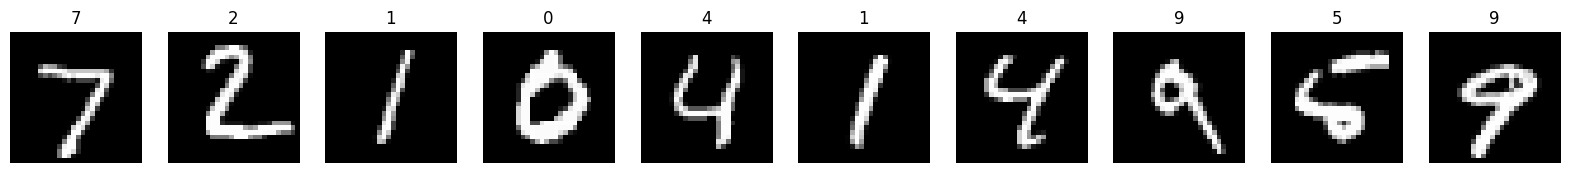

In [ ]:
import matplotlib.pyplot as plt

num_imgs_to_visualize = 10

figure = plt.figure(figsize=(20, 20))

for i in range(num_imgs_to_visualize):
    # here we indexing the Dataset-object "as is" and gettig a tuple (img, label)
    img, label = test_data[i]

    figure.add_subplot(1, num_imgs_to_visualize, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(label)
    plt.axis("off")
plt.show()

### Подготовка данных для обучения с помощью DataLoader

`Dataset` возвращает по одной паре "объект — метка" за раз. При обучении моделей мы обычно хотим получать обекты в виде мини-батчей, перемешивая данные на каждой эпохе для уменьшения переобучения.

`DataLoader` — это объект, который позволяет нам получать такие мини-батчи. При инициализации он принимает в себя объект `Dataset`, а также параметры `batch_size` (размер мини-батча) и `shuffle` (перемешивать ли данные в батчах каждую эпоху).

Другие параметры, а также значения по умолчанию можно посмотреть в документации PyTorch для класса [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False)

Так как мы имели два объекта класса `Dataset`: `train_data` и `test_data`, то мы создаем также и два независимых `DataLoader`-а. Один из них позволит нам получать батчи из обучающей выборки, а другой — из тестовой.

Обратите внимание на параметр `shuffle`! По умолчанию он имеет значение `False`. **Для обучения нейронной сети критически важно, чтобы во время обучения батчи обучающих данных перемешивались**. Именно таким образом мы вносим **стохастичность** в процесс градиентного спуска. Поэтому для `DataLoader`-a, который будет выдавать батчи для обучения, необходимо использовать `shuffle=True`.

В противоположность этому — `DataLoader` для тестовых данных. Тестовые данные служат для оценки качества работы модели, на них не происходит обучение и градиентный спуск. Поэтому установка здесь `shuffle=True` не имеет большого смысла.

### Итерирование по `DataLoader`

Мы загрузили набор данных в `DataLoader`, и теперь можем проходиться по нему по мере необходимости. Каждая итерация в коде ниже будет возвращать мини-батч в виде кортежа тензоров `(samples, labels)`, содержащих `batch_size=8` объектов и меток соответственно.
Так как мы установили для `train_dataloader` параметр `shuffle=True`, когда мы пройдемся по всем батчам, данные перемешаются.

Images batch shape: torch.Size([8, 1, 28, 28]) : [batch_size, num_channels, H, W]
Labels batch shape: torch.Size([8])

The first sample in the batch:


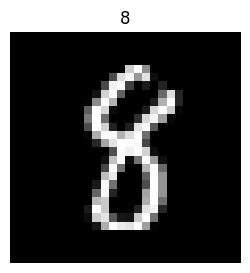

In [ ]:
# get one next batch
imgs, labels = next(iter(train_dataloader))

print(f"Images batch shape: {imgs.size()} : [batch_size, num_channels, H, W]")
print(f"Labels batch shape: {labels.size()}")

print("\nThe first sample in the batch:")
img = imgs[0].squeeze()
label = labels[0].item()

plt.figure(figsize=(3, 3))
plt.imshow(img, cmap="gray")
plt.title(label)
plt.axis("off")
plt.show()

## Трансформации (Transforms)

Данные не всегда поступают в том формате, который требуется для работы моделей машинного обучения. Для того, чтобы производить некоторые преобразования с данными и делать их пригодными для обучения, в PyTorch реализован механизм трансформаций (transforms).

Все наборы данных в Torchvision имеют два параметра: `transform` — для применения трансформаций к входным данным, и `target_transform` — соответственно для преобразования меток.
Эти параметры принимают в себя вызываемые (callable) объекты, содержащие логику преобразований. Модуль [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) предоставляет ряд часто используемых трансформаций "из коробки".

Важно понимать, что трансформации, указанные в `transform` и `target_transform`, **применяются к данным налету**, то есть в момент обращения к этим данным через `Dataset` или `DataLoader`.

### ToTensor

Изображения в MNIST (и в большинстве других встроенных датасетов) изначально хранятся в формате PIL Image (Python Image Library), а метки представлены как целые числа. Если с метками, представленными таким образом, ничего делать не нужно, то входные данные для обучения необходимо перевести в тензоры. Чтобы произвести эту трансформацию, выше при загрузке данных MNIST мы использовали [`torchvision.transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

`ToTensor` преобразует PIL Image или NumPy `ndarray` в `FloatTensor` **и масштабирует значения интенсивности пикселей к диапазону $[0., 1.]$**.

### Normalize

Предположим, что помимо перевода данных в подходящий формат мы бы хотели произвести какие-то преобразования с самими величинами. Скажем, произвести нормализацию: вычесть математическое ожидание и разделить на стандартное отклонение по выборке. Для проведения такой операции в `torchvision.transforms` предусмотрена трансформация [`Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html).

Два обязательных параметра в этой трансформации — это `mean` и `std`:
* `mean` — последовательность математических ожиданий по каждому каналу выборки изображений,
* `std` — последовательность стандартных отклонений по каждому каналу выборки изображений.

`Normalize` не применяется к PIL Image, поэтому ее необходимо применять после `ToTensor`.

Давайте вычислим среднее и стандартное отклонение для обучающей выборки MNIST. Для этого обратимся к `train_data.data`:

In [ ]:
import torch

print("train_data.data:")
print("Type: ", type(train_data.data))
print("Size: ", train_data.data.size())
print("Dtype:", train_data.data.dtype)
print("Max:  ", torch.max(train_data.data).item())
print("Min:  ", torch.min(train_data.data).item())

train_data.data:
Type:  <class 'torch.Tensor'>
Size:  torch.Size([60000, 28, 28])
Dtype: torch.uint8
Max:   255
Min:   0


`train_data.data` — тензор целых чисел (`uint8`) c минимальным значением 0 и максимальным значением 255. Функции `torch.mean()` и `torch.std()` выдадут ошибку, если передать им тензор целых чисел. Поэтому изменим тип на вещественный, применив метод `.double()`.

In [ ]:
mean = torch.mean(train_data.data.double()).item()
std = torch.std(train_data.data.double()).item()
print(f"mean = {mean:.2f}, std = {std:.2f}")

mean = 33.32, std = 78.57


Вспомним, что `Normalize` должна применяться после `ToTensor`, которая масштабирует величины в диапазон $[0., 1.]$. Значит, матожидание и стандартное отклонение мы также должны разделить на максимальное значение до масштабирования — на 255.

In [ ]:
mean /= 255
std /= 255
print(f"Scaled mean = {mean:.2f}, std = {std:.2f}")

Scaled mean = 0.13, std = 0.31


### Compose

Мы вычислили среднее и стандартное отклонение по обучающей выборке MNIST для применения транcформации `Normalize`. Но мы также помним, что она должна применяться только после `ToTensor`. Как же объединить несколько трансформаций в одну, чтобы они применились последовательно?

Для этого предусмотрен класс [`torchvision.transforms.Compose`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html). Его единственный параметр — список принимаемых трансформаций. `Compose` — это контейнер для трансформаций, при помещении в который они будут применяться поочерёдно. В общем случае их может быть сколько угодно. Давайте напишем трансформацию, которая примет в себя две: `ToTensor` и `Normalize`.

In [ ]:
from torchvision import transforms

transform_with_normalize = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

print(transform_with_normalize)

Compose(
    ToTensor()
    Normalize(mean=0.1306604762738429, std=0.30810780717887876)
)


Остается только подменить у обучающего и тестового датасетов ту трансформацию, которую мы указали при загрузке данных, на нашу новую — с нормализацией. Для этого посмотрим на атрибут `.transform` и изменим его.

In [ ]:
print("Old train transform:", train_data.transform)
print("Old test transform:", test_data.transform)

train_data.transform = transform_with_normalize
test_data.transform = transform_with_normalize

print("\nNew train transform:", train_data.transform)
print("New test transform:", test_data.transform)

Old train transform: ToTensor()
Old test transform: ToTensor()

New train transform: Compose(
    ToTensor()
    Normalize(mean=0.1306604762738429, std=0.30810780717887876)
)
New test transform: Compose(
    ToTensor()
    Normalize(mean=0.1306604762738429, std=0.30810780717887876)
)


Следует еще раз заметить, что при нормализации мы **вычисляем** оценки математического ожидания и стандартного отклонения `mean` и `std` **на обучающих данных**, а **применяем** вычисленные оценки **и на обучающих, и на тестовых данных**.

Теперь при обращении к данным через `DataLoader` будет происходить следующее:

1. Объект `DataLoader` обращается к объекту `Dataset` за данными, чтобы сформировать батч.
2. `Dataset` считывает данные, которые хранятся на диске, в формате PIL Image, применяет к ним трансформации, указанные в его атрибуте `.transform` (в данном случае это последовательность `ToTensor` и `Normalize`), и возвращает `DataLoader`-у преобразованные данные.
3. `DataLoader` формирует из полученных данных батч и возвращает его.

Обратите внимание, что на диске по-прежнему лежат просто изображения в своем специальном формате, и их довольно много. Но при этом в каждый момент времени мы не храним на диске все изображения как тензоры в сыром виде или в нормализованном. Нужные операции применяются к данным налету, только когда они нужны — при формировании батчей.

## Создание нейронной сети

Нейронные сети состоят из слоев, которые производят преобразования над данными. В PyTorch принято называть слои ***модулями*** (modules), и далее мы тоже будем использовать это название.

Пространство имен [`torch.nn`](https://pytorch.org/docs/stable/nn.html) предоставляет "строительные блоки", которые нужны для создания своей собственной нейронной сети. Каждый *модуль* в PyTorch является дочерним классом от [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Таким образом, нейронная сеть сама по себе будет являться *модулем*, состоящим из других *модулей* (слоев). Такая вложенная структура позволяет легко создавать сложные архитектуры и управлять ими.

Ниже мы рассмотрим пример создания нейронной сети для классификации изображений из набора данных MNIST.

### Выбор устройства (device) для обучения

Мы бы хотели иметь возможность обучать модель на аппаратном ускорителе, таком как GPU, если он доступен. Проверим, доступен ли нам ускоритель [`torch.cuda`](https://pytorch.org/docs/stable/notes/cuda.html), иначе продолжим вычисления на CPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Описание класса модели

Мы определяем нейронную сеть, наследуясь от класса `nn.Module`, и инициализируем ее слои в методе `__init__`. Каждый класс-наследник `nn.Module` производит операции над входными данными в методе `forward`.

Напишем собственную нейронную сеть как класс `NeuralNetwork`. Ниже подробно рассмотрим все составляющие ее части.

In [ ]:
from torch import nn


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)
        return logits

Создадим экземпляр класса `NeuralNetwork`, переместим его на `device` с помощью метода `to` и выведем информацию о структуре модели.

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


Чтобы использовать модель, мы передаем ей входные данные. Это приводит в действие метод `forward`, а также определенные фоновые операции. Не следует вызывать `model.forward` напрямую!

Вызов модели с входными данными возвращает тензор с двумя размерностями: нулевая размерность `dim=0` соответствует  количеству переданных примеров, а первая `dim=1` — десяти выходным "сырым" предсказаниям (логитам) для каждого класса.

Мы можем получить предсказание модели в виде вероятностей, пропустив логиты через экземпляр модуля `nn.Softmax`, вызвав его вычисление вдоль первой размерности `dim=1`.

In [ ]:
# random input of 3 images
sample_batch = torch.rand(
    3, 1, 28, 28, device=device
)  # [batch_size, num_channels, H, W]

# model output
logits = model(sample_batch)

# predicted probabilities
pred_probab = nn.Softmax(dim=1)(logits)

# predicted classes
y_pred = pred_probab.argmax(dim=1)

print(f"Input size:       {sample_batch.size()} : [batch_size, num_channels, H, W]")
print(f"Output size:      {logits.size()}        : [batch_size, num_classes]")
print(
    f"Predicted class:  {y_pred}          : [class for sample 1, class for sample 2, class for sample 3]"
)

Input size:       torch.Size([3, 1, 28, 28]) : [batch_size, num_channels, H, W]
Output size:      torch.Size([3, 10])        : [batch_size, num_classes]
Predicted class:  tensor([7, 7, 7], device='cuda:0')          : [class for sample 1, class for sample 2, class for sample 3]


### Слои модели

Давайте заглянем "под капот" нашей модели `NeuralNetwork`. Для иллюстрации возьмем мини-батч из трех одноканальных изображений 28×28 и посмотрим, что с ним происходит, когда мы пропускаем его через сеть.

In [ ]:
sample_batch = torch.rand(3, 1, 28, 28)
print(f"Input size: {sample_batch.size()}")

Input size: torch.Size([3, 1, 28, 28])


#### Слой `nn.Flatten`

Мы используем слой [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) для преобразования каждого изображения 1×28×28 пикселей в непрерывный массив из 784 значений (размер батча (на позиции `dim=0`) сохраняется).

In [ ]:
flatten = nn.Flatten()
flat_image = flatten(sample_batch)
print(f"Size after Flatten: {flat_image.size()}")

Size after Flatten: torch.Size([3, 784])


#### Слой `nn.Linear`

Линейный слой [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) — это модуль, который производит линейное преобразование входных данных с помощью хранящихся в нем весов и смещений.

Обязательными параметрами при объявлении этого слоя являются `in_features` — количество входных признаков, и `out_features` — количество выходных признаков.

Фактически, этот модуль добавляет в модель один полносвязный слой нейронов *без активаций*. Слой состоит из `out_features` нейронов, каждый из которых имеет `in_features` входов.

В примере ниже мы объявляем слой из 512 нейронов, каждый из которых получает "вытянутое" изображение из 784 пикселей.

In [ ]:
layer1 = nn.Linear(in_features=784, out_features=512)
hidden1 = layer1(flat_image)
print(f"Size after Linear:  {hidden1.size()}")

Size after Linear:  torch.Size([3, 512])


Линейный слой, в отличие от слоя `nn.Flatten`, имеет обучаемые параметры — веса и смещения. Они хранятся как объекты специального класса `torch.nn.parameter.Parameter` и содержат в себе тензоры собственно с величинами параметров. Получить доступ к ним можно, обратившись к атрибутам слоя `.weight` и `.bias` соответственно.

In [ ]:
print(f"Size of linear layer weights: {layer1.weight.size()}")
print(f"Type of linear layer weights: {type(layer1.weight)}")

print(f"\nSize of linear layer biases: {layer1.bias.size()}")
print(f"Type of linear layer biases: {type(layer1.bias)}")

Size of linear layer weights: torch.Size([512, 784])
Type of linear layer weights: <class 'torch.nn.parameter.Parameter'>

Size of linear layer biases: torch.Size([512])
Type of linear layer biases: <class 'torch.nn.parameter.Parameter'>


#### Слой `nn.ReLU`

Нелинейные активации — это то, что позволяет модели учить сложные взаимосвязи между входом и выходом. Они применяются после линейных преобразований, чтобы ввести *нелинейность*, помогая нейронным сетям изучать самые разные закономерности.

В данной модели мы используем [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) между линейными слоями, но существуют и реализации [других функций активации](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

In [ ]:
activations1 = nn.ReLU()(hidden1)

print(f"Before ReLU:  {hidden1}")
print(f"After ReLU:  {activations1}")
print(f"\n Size after ReLU:  {activations1.size()}")

Before ReLU:  tensor([[ 0.0761, -0.0194, -0.2215,  ...,  0.1836, -0.2779,  0.0627],
        [ 0.3971,  0.0891, -0.6315,  ...,  0.3182, -0.2746,  0.2194],
        [ 0.3238, -0.0899, -0.7042,  ...,  0.1712, -0.0055,  0.0566]],
       grad_fn=<AddmmBackward0>)
After ReLU:  tensor([[0.0761, 0.0000, 0.0000,  ..., 0.1836, 0.0000, 0.0627],
        [0.3971, 0.0891, 0.0000,  ..., 0.3182, 0.0000, 0.2194],
        [0.3238, 0.0000, 0.0000,  ..., 0.1712, 0.0000, 0.0566]],
       grad_fn=<ReluBackward0>)

 Size after ReLU:  torch.Size([3, 512])


#### Объединение модулей в `nn.Sequential`

[`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) — это упорядоченный контейнер для модулей. Данные проходят через все модули в том же порядке, в котором они определены в `nn.Sequential`. Можно использовать такой контейнер для того, чтобы быстро собрать простую нейронную сеть, как `seq_modules` в примере ниже.

In [ ]:
seq_modules = nn.Sequential(flatten, layer1, nn.ReLU(), nn.Linear(512, 10))

sample_batch = torch.rand(3, 1, 28, 28)
logits = seq_modules(sample_batch)

print(f"Output size: {logits.size()}")

Output size: torch.Size([3, 10])


#### Слой `nn.Softmax`

Последний линейный слой нейронной сети возвращает *логиты* — "сырые" значения из диапазона $[-∞; +∞]$, которые могут быть пропущены через модуль [`nn.Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html). Пропущенные через $\text{sofmax}$ величины могут восприниматься как вероятности, с которыми модель относит данный объект к тому или иному классу. Параметр `dim` определяет размерность, вдоль которой величины должны суммироваться к $1$.

In [ ]:
softmax = nn.Softmax(dim=1)

pred_probab = softmax(logits)

print(f"Size after Softmax: {pred_probab.size()}")

Size after Softmax: torch.Size([3, 10])


### Параметры модели

Множество слоев в нейронных сетях имеют *обучаемые параметры*, т. е. имеют ассоциированные с ними веса и смещения, которые оптимизируются во время обучения.

Наследование от `nn.Module` автоматически отслеживает все слои, определенные внутри вашего класса модели, и делает все их параметры доступными с помощью методов `model.parameters()` или `model.named_parameters()`.

В примере ниже мы проходимся по всем параметрам модели, и для каждого тензора параметров выводим его размер.

In [ ]:
print(f"Model structure: {model}\n")

for name, param in model.named_parameters():
    print(f"Layer: {name:25}  Size: {param.size()}")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

Layer: layers_stack.0.weight      Size: torch.Size([512, 784])
Layer: layers_stack.0.bias        Size: torch.Size([512])
Layer: layers_stack.2.weight      Size: torch.Size([128, 512])
Layer: layers_stack.2.bias        Size: torch.Size([128])
Layer: layers_stack.4.weight      Size: torch.Size([10, 128])
Layer: layers_stack.4.bias        Size: torch.Size([10])


## Обучение нейронной сети

Теперь, когда у нас есть данные и модель, настало время ее обучить, то есть оптимизировать ее параметры на обучающих данных.

Обучение модели — итеративный процесс. На каждой итерции модель получает входные данные, дает предсказание на выходе, вычисляет значение функции потерь (loss), вычисляет производные функции потерь по параметрам и подстраивает параметры, используя градиентный спуск. Для более детального рассмотрения этого процесса рекомендуем посмотреть [видео об обратном распространении ошибки от 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

[Плейлист с видео о нейронных сетях от 3Blue1Brown с озвучкой на русском](https://www.youtube.com/playlist?list=PLfdZ2TeaMzfzlpZ60rbaYU_epH5XPNbWU).

### Гиперпараметры

Гиперпараметры — это задаваемые разработчиком параметры, которые позволяют управлять процессом обучения. Различные значения гиперпараметров могут влиять на обучение модели и скорость сходимости ([здесь](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) можно почитать подробнее про подбор гиперпараметров).

Мы определим следующие гиперпараметры процедуры обучения:
* **количество эпох** (`num_epochs`) — количество итераций обучения по всему набору данных;
* **размер батча** (`batch_size`) — количество образцов, передаваемых в сеть для обновления параметров;
* **скорость обучения** (`learning_rate`) — коэффициент, определяющий, насколько сильно нужно обновлять параметры модели на каждом батче. Малые значения приводят к долгому обучению, в то время как большие значения могут приводить к непредсказуемому поведению во время обучения.


In [ ]:
num_epochs = 10
batch_size = 64
learning_rate = 1e-3

Выше для демонстрации мы указывали размер батча в `DataLoader`-ах равным восьми. Для установки нового значения придется переопределить `DataLoader`-ы.

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Оптимизация параметров (обучение сети)

Задав гиперпараметры, мы можем приступить к обучению модели. Каждая итерация цикла оптимизации называется **эпохой**.

Каждая эпоха состоит из двух частей:
* **цикл обучения (Train Loop)** — проход по обучающему набору данных и оптимизация параметров;
* **цикл валидации (Validation Loop)** — проход по валидационному/тестовому набору данных и контроль того, что качество работы сети улучшается.

Кратко ознакомимся с некоторыми понятиями, используемыми в цикле оптимизации.

#### Функция потерь (Loss function)

При получении некоторых обучающих данных наша необученная сеть, скорее всего, не даст правильного ответа. Функция потерь измеряет степень различия между значениями на выходе сети и целевыми значениями. Именно функцию потерь мы и хотим минимизировать во время обучения. Для вычисления функции потерь нужно получить предсказание модели, передав ей на вход пример из данных, и сравнить его с истинным значением целевой переменной.

Наиболее часто применяемыми функциями потерь являются [`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) для задач регрессии и [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) для задач класиификации.


Мы будем передавать выходы модели (логиты) в `nn.CrossEntropyLoss`, которая будет их нормализовывать и вычислять ошибку предсказания.

In [ ]:
# Initialize the loss function
criterion = nn.CrossEntropyLoss()

#### Оптимизатор (Optimizer)

Оптимизация — это процесс подстройки параметров модели для уменьшения ошибки на каждом шаге обучения. От **алгоритма оптимизации** зависит то, как этот процесс будет выполняться. Здесь мы будем использовать стохастический градиентный спуск (Stochastic Gradient Descent, SGD). Однако в PyTorch реализовано еще [множество других алгоритмов оптимизации](https://pytorch.org/docs/stable/optim.html#algorithms), таких как Adam и RMSProp, и они могут работать лучше или хуже для разных видов моделей и данных.

Вся логика оптимизации заключена в объекте `optimizer`. Мы инициализируем оптимизатор, передавая ему параметры модели, которые требуется обучать (`model.parameters()`), а также гиперпараметр скорости обучения (`learning_rate`).

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Внутри цикла обучения, оптимизация производится за три шага:
1. Вызов `optimizer.zero_grad()`, чтобы сбросить градиенты параметров модели. По умолчанию градиенты суммируются, и во избежание повторного вычисления их необходимо явно обнулять на каждой итерации;
2. Обратное распространение ошибки предсказания с помощью вызова `loss.backward()`. PyTorch вычислит градиенты функции потерь относительно каждого обучаемого параметра;
3. Когда у нас есть градиенты, мы вызываем `optimizer.step()`, чтобы подстроить обучаемые параметры с учетом градиентов, посчитанных при обратном распространении, согласно алгоритму оптимизации.


### Реализация обучения

Мы определим две функции:
* `train_loop`, которая производит цикл обучения,
* `test_loop`, которая оценивает качество модели на тестовых данных.

In [ ]:
def train_loop(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        # Compute prediction and loss
        pred = model(imgs.to(device))
        loss = criterion(pred, labels.to(device))

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device))
            loss = criterion(pred, labels.to(device))

            test_loss += loss.item()
            correct += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )

    test_loss /= num_batches
    correct /= size
    print(f"Test loss: {test_loss:>8f}, test accuracy: {(100*correct):>0.1f}% \n")

    return test_loss

Выше мы объявили гиперпараметры и инициализировали функцию потерь `criterion` и оптимизатор `optimizer`. Теперь мы запускаем цикл оптимизации на 10 эпох, и в каждой итерации мы вызываем функцию для выполнения цикла обучения `train_loop`, а затем функцию для промежуточной оценки качества `test_loop`. Также на каждой эпохе будем сохранять текущее значение функции потерь на обучающих и тестовых данных для построения графика обучения.

In [ ]:
# for plotting
loss_history = {"train": [], "test": []}

for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    test_loss = test_loop(test_dataloader, model, criterion)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print("Done!")

Epoch 1
Train loss: 2.129134
Test loss: 1.867858, test accuracy: 67.3% 

Epoch 2
Train loss: 1.485368
Test loss: 1.080338, test accuracy: 78.6% 

Epoch 3
Train loss: 0.877476
Test loss: 0.692152, test accuracy: 84.2% 

Epoch 4
Train loss: 0.628923
Test loss: 0.538475, test accuracy: 86.9% 

Epoch 5
Train loss: 0.515250
Test loss: 0.456962, test accuracy: 88.3% 

Epoch 6
Train loss: 0.450605
Test loss: 0.408414, test accuracy: 89.2% 

Epoch 7
Train loss: 0.409812
Test loss: 0.376002, test accuracy: 89.8% 

Epoch 8
Train loss: 0.381615
Test loss: 0.353203, test accuracy: 90.3% 

Epoch 9
Train loss: 0.360897
Test loss: 0.337453, test accuracy: 90.5% 

Epoch 10
Train loss: 0.345000
Test loss: 0.323591, test accuracy: 90.8% 

Done!


Построим график функции потерь на обучающих и на тестовых данных по эпохам:

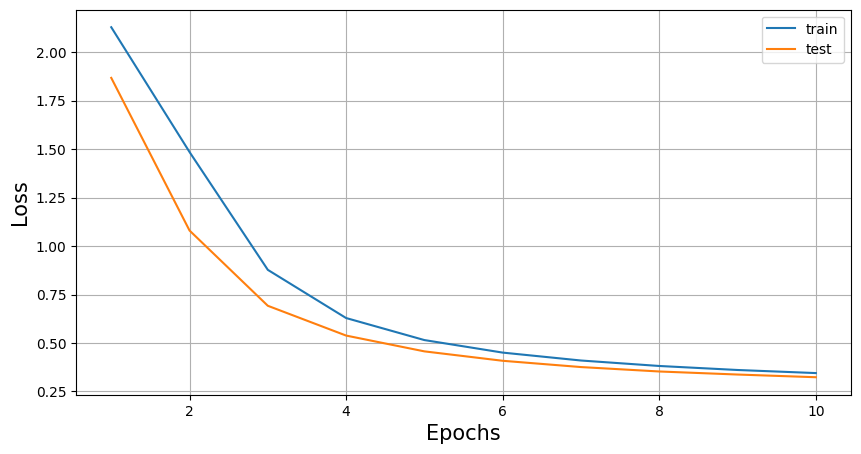

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.grid()
plt.show()

###  Посмотрим на предсказания обученной модели

Поэтапно пропустим тестовые изображения через модель и визуализируем результат

In [ ]:
# get batch
imgs, labels = next(iter(test_dataloader))
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([64, 1, 28, 28])


In [ ]:
# get output
pred = model(imgs.to(device))
print("pred shape: ", pred.shape)

pred shape:  torch.Size([64, 10])


In [ ]:
# First sample in prediction batch
pred[0]

tensor([ 0.0246, -4.8137, -0.5842,  1.5116, -1.7782, -0.2193, -6.6226,  8.8951,
        -1.3204,  3.2529], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
# Calculate probabilities
nn.Softmax(dim=0)(pred[0].detach())

tensor([1.3985e-04, 1.1076e-06, 7.6077e-05, 6.1865e-04, 2.3051e-05, 1.0958e-04,
        1.8147e-07, 9.9547e-01, 3.6435e-05, 3.5291e-03], device='cuda:0')

In [ ]:
# remove axis
imgs = torch.reshape(imgs, (64, 28, 28))
print("imgs shape(after reshape): ", imgs.shape)

imgs shape(after reshape):  torch.Size([64, 28, 28])


In [ ]:
# take 10 first images
imgs = imgs[:10]
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([10, 28, 28])


In [ ]:
import numpy as np

pred = pred[:10].detach()
print("Prediction(1 sample):\n", pred[0])
digits = np.argmax(pred.cpu().numpy(), axis=1)
print("Predicted class: ", digits[0])

Prediction(1 sample):
 tensor([ 0.0246, -4.8137, -0.5842,  1.5116, -1.7782, -0.2193, -6.6226,  8.8951,
        -1.3204,  3.2529], device='cuda:0')
Predicted class:  7


Визуализируем изображения, подпишем предсказанное и истинное значение:

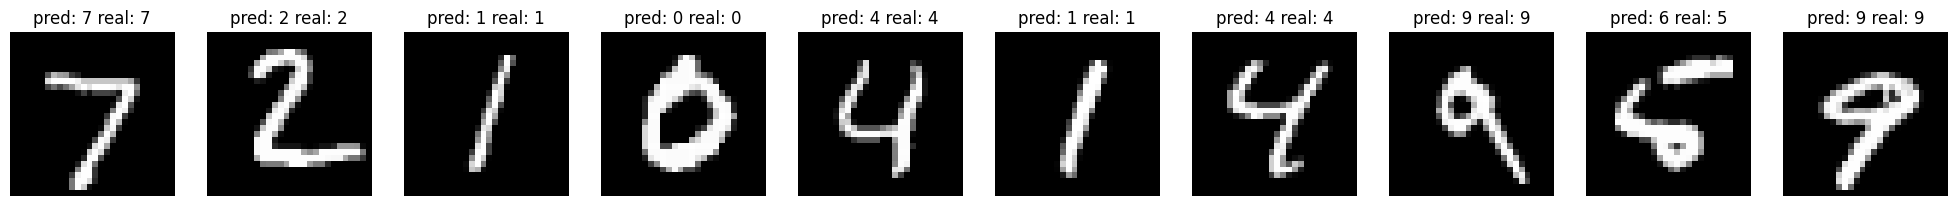

In [ ]:
plt.figure(figsize=(25.0, 25.0))
for i in range(10):
    img = imgs[i]

    plt.subplot(1, 10, i + 1)
    plt.title(
        "pred: " + str(digits[i]) + " real: " + str(labels[i].numpy())
    )  # predicted and real values
    plt.axis("off")
    plt.imshow(img.numpy(), cmap="gray")

## Сохранение и загрузка весов модели

Обычно обучение модели является достаточно затратным процессом с точки зрения вычислительных ресурсов. Поэтому, однажды обучив сеть, разумно будет сохранить ее для последующего использования. Рассмотрим варианты, как это можно сделать в PyTorch.

Модели PyTorch хранят обучаемые параметры во внутреннем словаре состояния, который называется `state_dict`. Их можно сохранить с помощью метода `torch.save`.


In [ ]:
torch.save(model.state_dict(), "model_weights.pth")

Для того, чтобы загрузить веса модели, сперва необходимо создать экземпляр такой модели, а затем загрузить параметры с помощью метода `load_state_dict()`.

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model_weights.pth"))
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


<font size="6">Ссылки:</font>

[StatSoft. Радиальная базисная функция](http://statsoft.ru/home/textbook/modules/stneunet.html#radial)

[Understanding Loss Functions in Machine Learning](https://www.section.io/engineering-education/understanding-loss-functions-in-machine-learning/)

[Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, Softmax Loss, Logistic Loss, Focal Loss and all those confusing names](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

[Объясненные современные функции активации: GELU, SELU, ELU, ReLU и другие](https://www.kdnuggets.com/2022/06/activation-functions-work-deep-learning.html)

Видеолекции курса А. Г. Дьяконова "Глубокое обучение" на тему PyTorch: [часть 1](https://www.youtube.com/watch?v=tDJnwc8Hioc), [часть 2](https://www.youtube.com/watch?v=c3y--ydWku0).